# Imports and helper functions

In [41]:
import os
# change directory in order to be able to import python scripts from the common package
if os.getcwd().endswith('jumping'): os.chdir(os.path.expanduser(".."))

In [42]:
import torch
import matplotlib.pylab as plt
import numpy as np

from gym_jumping_task.envs.jumping_task import JumpTaskEnv
from env import VanillaEnv
from env import generate_expert_episode
from common import psm


In [43]:

def compare2_imgs(a,b,title1, title2, scale=3, compare_idx=0):
   fig = plt.figure(figsize=(scale*2, scale))
   axarr = [fig.add_subplot(121), fig.add_subplot(122)]
   axarr[0].imshow(np.flipud(a.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(np.flipud(b.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[0].title.set_text(title1)
   axarr[1].title.set_text(title2)
   # plt.savefig(f"{compare_idx}.pdf", bbox_inches='tight', pad_inches=0)
   plt.show()
   

def compare_imgs(a,b,c,title1, title2, title3, scale=3, compare_idx=0):
   fig = plt.figure(figsize=(scale*3, scale))
   axarr = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]
   axarr[0].imshow(np.flipud(a.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(np.flipud(b.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[2].imshow(np.flipud(c.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[0].title.set_text(title1)
   axarr[1].title.set_text(title2)
   axarr[2].title.set_text(title3)
   # plt.savefig(f"{compare_idx}.pdf", bbox_inches='tight', pad_inches=0)
   plt.show()
   

In [58]:
states_x, actions_x = generate_expert_episode(VanillaEnv(configurations=[(40, 30)]))
states_y, actions_y = generate_expert_episode(VanillaEnv(configurations=[(30, 12)]))

# Manual calculation of PSE

First MPD:
| $x_n \sim \mathcal{X}$ | $x_1$  | $x_2$  | $x_3$|$x_4$|$x_5$|
|-:|:-:|:-:|:-:|:-:|:-:|
| $\pi_\mathcal{X}^*(x)$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}0\\1\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|
| $\arg \max(\pi_\mathcal{X}^*(x))$ |0|0|0|1|0|

Second MPD:
| $y_n \sim \mathcal{Y}$|$y_1$|$y_2$|$y_3$|$y_4$|$y_5$|
|-:|:-:|:-:|:-:|:-:|:-:|
| $\pi_\mathcal{Y}^*(y)$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}0\\1\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|
| $\arg \max(\pi_\mathcal{Y}^*(y))$ |0|1|0|0|0|

$
\begin{align}
d^*(x,y) &= TV(\pi_\mathcal{X}^*(\cdot |x), \pi_\mathcal{Y}^*(\cdot |y)) + \gamma W_1(d^*)\left( P_\mathcal{X}^{\pi^*}(\cdot|x),P_\mathcal{Y}^{\pi^*}(\cdot|y) \right) 
\\
d^*(x_i,y_j) &= TV(\arg \max(\pi_\mathcal{X}^*(x_i)),\arg \max(\pi_\mathcal{Y}^*(y_j))) + \gamma d^*(x_{i+1}, y_{j+1})
\\
d^*(x_i,y_j) &= TV(a_{\mathcal{X}, i}^*,a_{\mathcal{Y}, i}^*) + \gamma d^*(x_{i+1}, y_{j+1})
\\[.4cm]
\text{for two specific states (see table above):}
\\
d^*(x_2,y_2) &= TV(0,1) + \gamma \cdot d^*(x_3,y_3) \\
&= TV(0,1) + \gamma \cdot TV(0,0) + \gamma^2  \cdot TV(1,0) + \gamma^3 \cdot TV(0,0) \\
&= 1 + \gamma^2 = 1.9801
\end{align}
$

|$d(x_1, y_1)$|$d(x_1, y_2)$|$d(x_1, y_3)$|$d(x_1, y_4)$|$d(x_1, y_5)$|
|:-:|:-:|:-:|:-:|:-:|
|$d(x_2, y_1)$|$d(x_2, y_2)$|$d(x_2, y_3)$|$d(x_2, y_4)$|$d(x_2, y_5)$|
|$d(x_3, y_1)$|$d(x_3, y_2)$|$d(x_3, y_3)$|$d(x_3, y_4)$|$d(x_3, y_5)$|
|$d(x_4, y_1)$|$d(x_4, y_2)$|$d(x_4, y_3)$|$d(x_4, y_4)$|$d(x_4, y_5)$|
|$d(x_5, y_1)$|$d(x_5, y_2)$|$d(x_5, y_3)$|$d(x_5, y_4)$|$d(x_5, y_5)$|

$d(x_5, y_5) = TV(a_{x5}, a_{y5}) = TV(0,0) = 0$ <br>
$d(x_4, y_4) = TV(a_{x4}, a_{y4}) + \gamma \cdot TV(a_{x5}, a_{y5}) = TV(1,0) = 1$ <br>
$d(x_3, y_3) = TV(a_{x3}, a_{y3}) + \gamma \cdot TV(a_{x4}, a_{y4}) = TV(0,0) + \gamma \cdot 1 = 0.99$ <br>
$d(x_2, y_2) = TV(a_{x2}, a_{y2}) + \gamma \cdot TV(a_{x3}, a_{y3}) = TV(0,1) + \gamma \cdot 0.99 = 1.9801$ <br>
$d(x_1, y_1) = TV(a_{x1}, a_{y1}) + \gamma \cdot TV(a_{x2}, a_{y2}) = TV(0,0) + \gamma \cdot 1.9801 = 1.960299$ <br>

Is the following really correct? If there is no state $y_{i+1}$ then we just take $y_{i}$? Where is this indicated in the formulars? 

$d(x_4, y_5) = TV(a_{x4}, a_{y5}) + \gamma \cdot TV(a_{x5}, a_{y5}) = TV(1,0) + \gamma \cdot 0 = 1$<br>
$d(x_3, y_5) = TV(a_{x3}, a_{y5}) + \gamma \cdot TV(a_{x4}, a_{y5}) = TV(0,0) + \gamma \cdot 1 = 0.99$<br>
$d(x_2, y_5) = TV(a_{x2}, a_{y5}) + \gamma \cdot TV(a_{x3}, a_{y5}) = TV(0,0) + \gamma \cdot 0.99 = 0.9801$<br>
$d(x_1, y_5) = TV(a_{x1}, a_{y5}) + \gamma \cdot TV(a_{x2}, a_{y5}) = TV(0,0) + \gamma \cdot 0.9801 = 0.970299$<br>

Without recursion: <br>
$\begin{align}
d(x_1, y_3) &= \gamma^0 TV(a_{x1}, a_{y3}) + \gamma^1 TV(a_{x2}, a_{y4}) + \gamma^2 TV(a_{x3}, a_{y5}) + \gamma^3 TV(a_{x4}, a_{y5}) + \gamma^4 TV(a_{x5}, a_{y5})\\
&= \gamma^0 TV(0,0) + \gamma^1 TV(0,0) + \gamma^2 TV(0,0) + \gamma^3 TV(1,0) + \gamma^4 TV(0,0)\\
&=  \gamma^3 = 0.970299
\end{align}$


# PSE on dummy transitions

In [45]:
# calculate PSM for specific states x and y
def psm_single(x_arr, y_arr, x_idx, y_idx, gamma=0.9):
    """
    Calculates the psm for the enire sequence (starting at the first element)
    """
    tv = 0. if x_arr[x_idx] == y_arr[y_idx] else 1.
    if(x_idx == len(x_arr)-1 and y_idx == len(y_arr)-1):
        return tv
    else:
        return tv + gamma * psm_single(x_arr,y_arr, min(x_idx+1, len(x_arr)-1), min(y_idx+1, len(y_arr)-1), gamma)


for i in range(0,5):
    for j in range(0,5):
        print(f"{psm_single([0,0,0,0,1,0], [0,0,0,1,0,0], x_idx = i, y_idx=j):.6f}", end=', ')
    print("")

1.385100, 1.466100, 1.556100, 1.656100, 0.656100, 
0.000000, 1.539000, 1.629000, 1.729000, 0.729000, 
1.539000, 0.000000, 1.710000, 1.810000, 0.810000, 
1.629000, 1.710000, 0.000000, 1.900000, 0.900000, 
1.729000, 1.810000, 1.900000, 0.000000, 1.000000, 


In [46]:
Mx = torch.tensor([0,0,0,1,0])#.to('cuda:0')
My = torch.tensor([0,20,0,0,0])#.to('cuda:0')

In [47]:
# calculate it like in the paper
print(psm.psm_f_fast(Mx, My))

tensor([[1.6290, 1.7290, 0.7290, 0.7290, 0.7290],
        [1.7100, 1.8100, 0.8100, 0.8100, 0.8100],
        [0.9000, 1.9000, 0.9000, 0.9000, 0.9000],
        [1.9000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9000, 1.0000, 0.0000, 0.0000, 0.0000]])


In [48]:
# calculate psm for all states from X and Y 
print(psm.psm_default(Mx, My))

tensor([[1.9960, 1.9970, 0.9970, 0.9970, 0.9970],
        [1.9970, 1.9980, 0.9980, 0.9980, 0.9980],
        [0.9990, 1.9990, 0.9990, 0.9990, 0.9990],
        [1.9990, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9990, 1.0000, 0.0000, 0.0000, 0.0000]])


In [49]:
# calcualte psm forward and backward
print(psm.psm_fb(Mx, My))

tensor([[1.9603, 2.9703, 1.9603, 1.9504, 1.9406],
        [1.9701, 2.9801, 1.9701, 1.9602, 1.9504],
        [0.9900, 2.9900, 1.9800, 1.9701, 1.9603],
        [2.9900, 2.0000, 2.9900, 2.9801, 2.9703],
        [1.9800, 2.9900, 0.9900, 1.9701, 1.9603]])


In [50]:
# calcualte psm forward and backward fast
print(psm.psm_fb_fast(Mx, My))

tensor([[1.6290, 2.7290, 1.6290, 1.5390, 1.4580],
        [1.7100, 2.8100, 1.7100, 1.6200, 1.5390],
        [0.9000, 2.9000, 1.8000, 1.7100, 1.6290],
        [2.9000, 2.0000, 2.9000, 2.8100, 2.7290],
        [1.8000, 2.9000, 0.9000, 1.7100, 1.6290]])


# PSE on jumping task

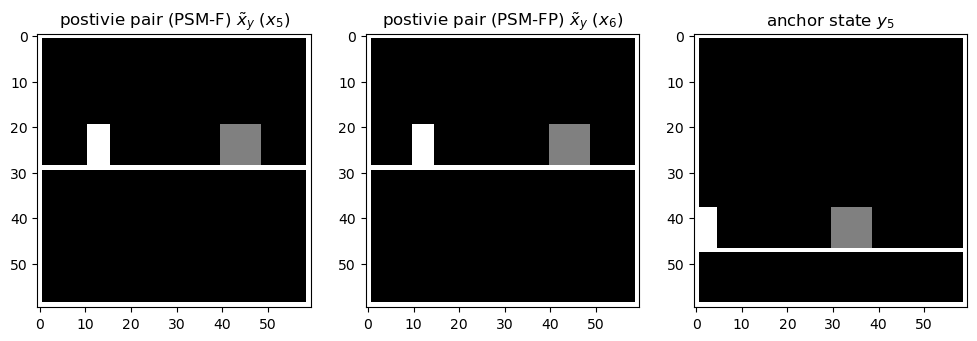

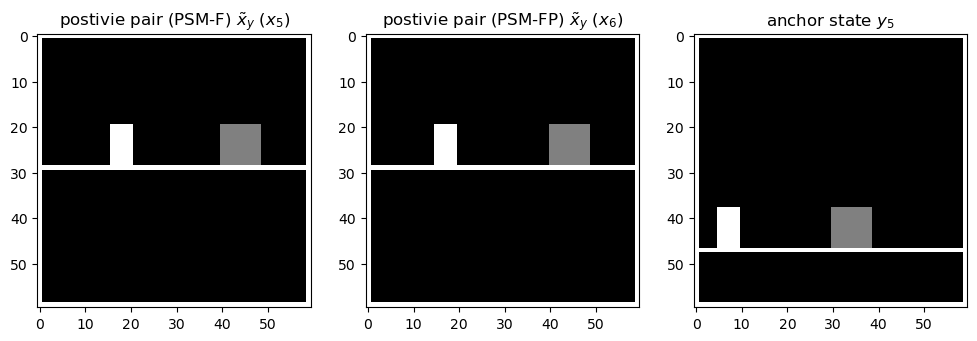

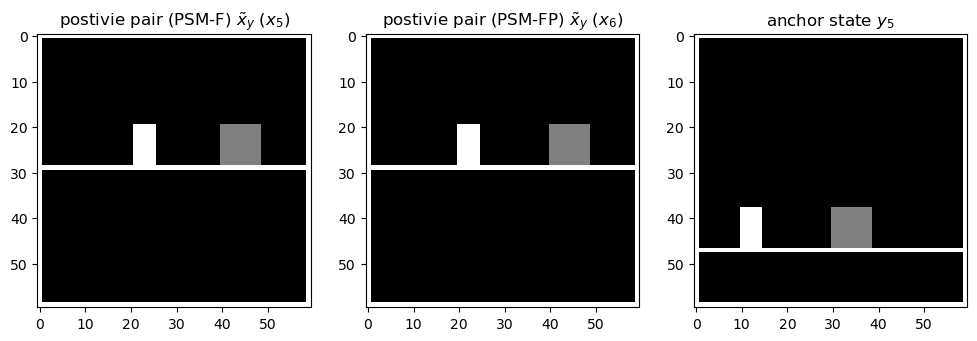

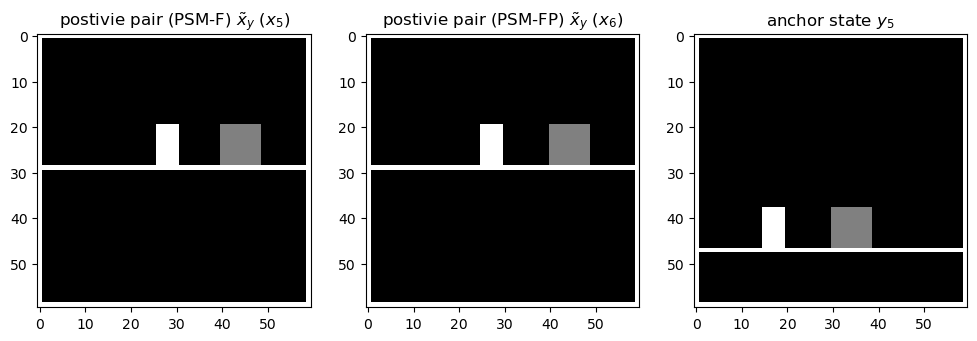

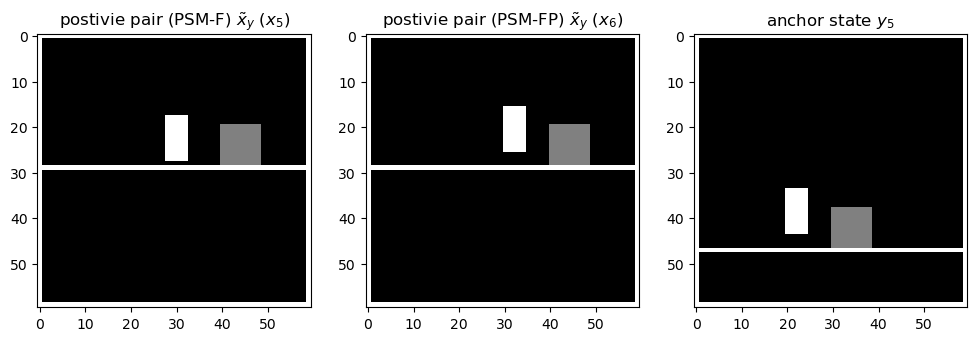

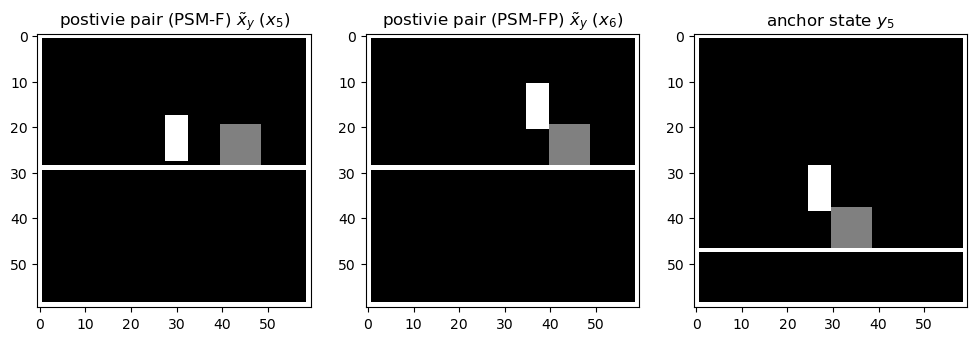

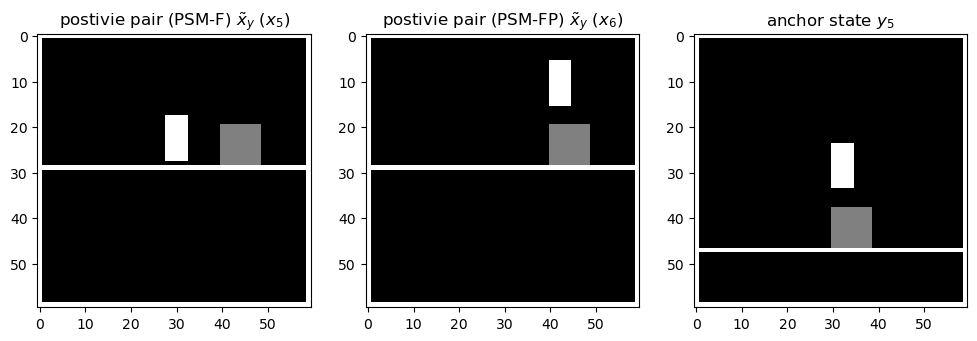

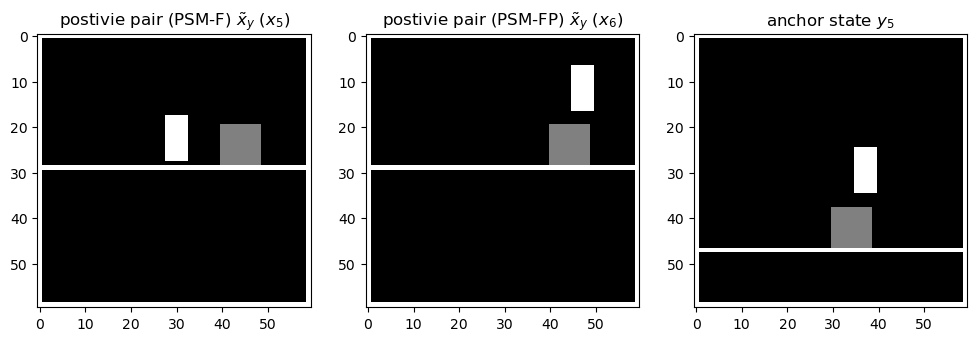

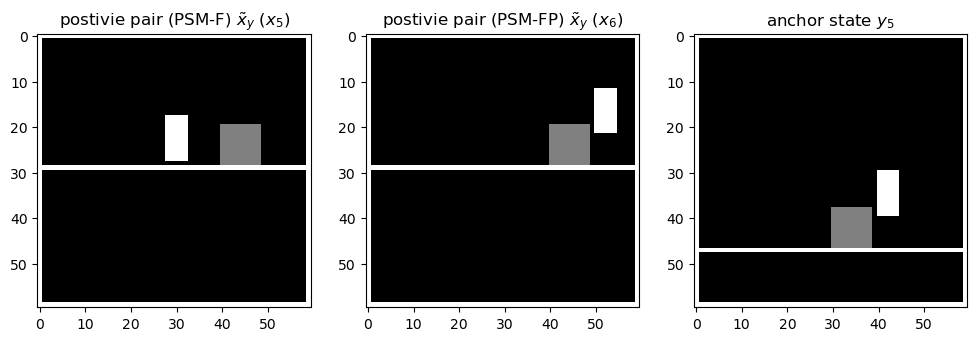

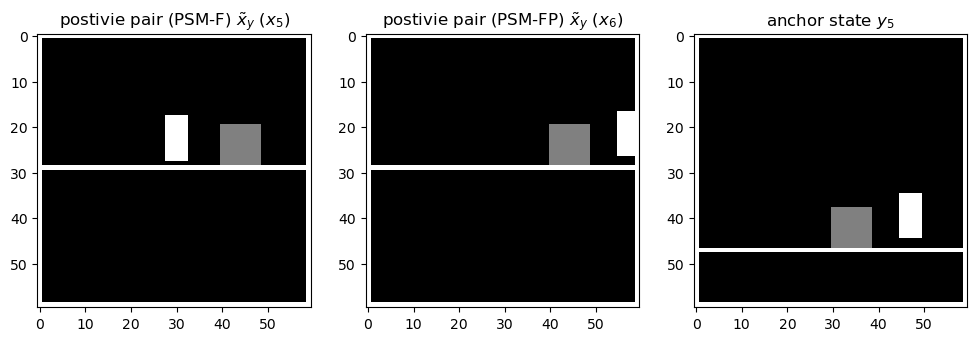

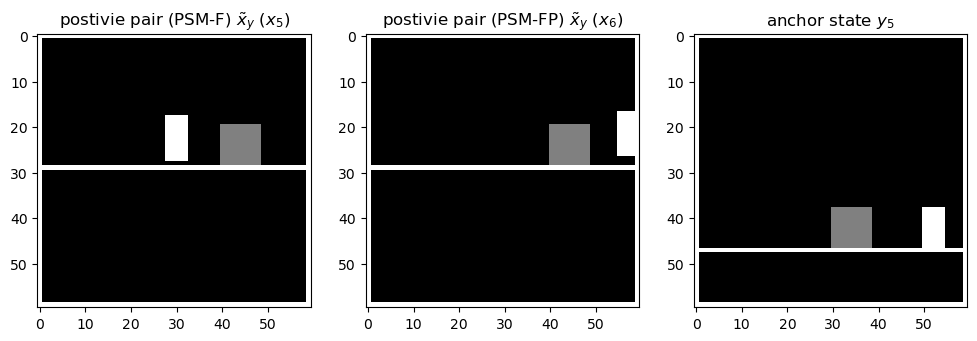

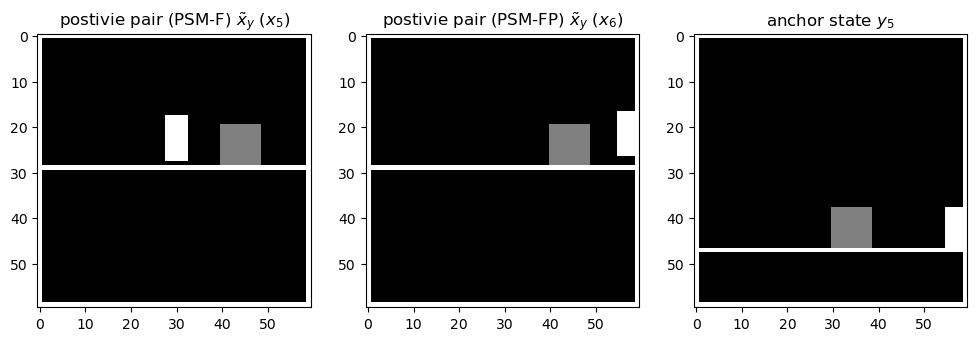

In [76]:
psm_forward = psm.psm_default(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.9)
psm_fb = psm.psm_fb(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.9)

psm_forward_fast = psm.psm_f_fast(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.9)
psm_fb_fast = psm.psm_fb_fast(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.9)

assert np.allclose(psm_forward, psm_forward_fast) , "Different psm values for fast and slow version!"
assert np.allclose(psm_fb, psm_fb_fast) , "Different psm values for fast and slow version!"

beta = 0.01
# psm_forward = np.exp(-psm_forward / beta)
# psm_fb = np.exp(-psm_fb / beta)

for compare_idx in range(0, len(actions_y)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    idx_forward = np.argmin(psm_forward[:, compare_idx])
    idx_fb = np.argmin(psm_fb[:,compare_idx])

    if compare_idx % 5 == 0:
        compare_imgs(
            states_x[idx_forward+1], 
            states_x[idx_fb], 
            states_y[compare_idx], 
            # "Positive pair $\\tilde{x}_y$ $d(x_3, y_3)$" + f"{psm_forward[idx_forward, compare_idx].item():.2f}",
            "postivie pair (PSM-F) $\\tilde{x}_y$ ($x_5$)",
            "postivie pair (PSM-FP) $\\tilde{x}_y$ ($x_6$)",
            # "Positive pair $\\tilde{x}_y$ (PSM fb): "  + f"{psm_fb[idx_fb, compare_idx].item():.6f}", 
            "anchor state $y_5$",
            scale=4)
        


tensor([0.9483, 0.9482, 0.9480, 0.9478, 0.9475, 0.9472, 0.9467, 0.9462, 0.9455,
        0.9447, 0.9436, 0.9423, 0.9406, 0.9385, 0.9360, 0.9328, 0.9288, 0.9238,
        0.9176, 0.9099, 1.0000, 0.8887, 0.8743, 0.8566, 0.8349, 0.8086, 0.6361,
        0.8086, 0.8349, 0.8566, 0.8743, 0.8887, 0.9005, 0.9099, 0.9176, 0.9238,
        0.9288, 0.9328, 0.9360, 0.9385, 0.9406, 0.9423, 0.9436, 0.9447, 0.9455,
        0.9462, 0.9467, 0.9472, 0.9475, 0.9478, 0.9480, 0.9482, 0.9483, 0.9485,
        0.9486, 0.9486])


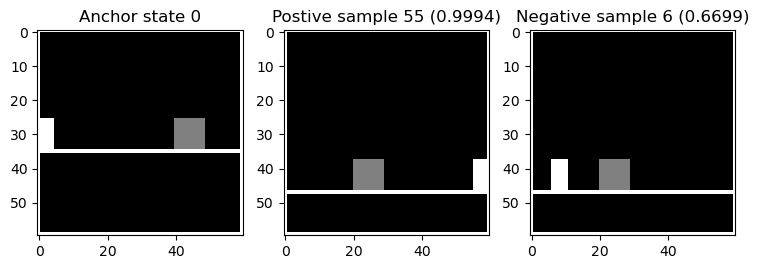

tensor([0.8793, 0.8792, 0.8790, 0.8788, 0.8786, 0.8782, 0.8778, 0.8773, 0.8767,
        0.8759, 0.8749, 0.8737, 0.8721, 0.8702, 0.8678, 0.8649, 0.8612, 0.8565,
        0.8508, 0.8437, 0.8349, 0.8240, 0.8106, 0.7942, 1.0000, 0.7498, 0.5898,
        0.7498, 0.7741, 0.7942, 0.8106, 0.8240, 0.8349, 0.8437, 0.8508, 0.8565,
        0.8612, 0.8649, 0.8678, 0.8702, 0.8721, 0.8737, 0.8749, 0.8759, 0.8767,
        0.8773, 0.8778, 0.8782, 0.8786, 0.8788, 0.8790, 0.8792, 0.8793, 0.8794,
        0.8795, 0.8796])


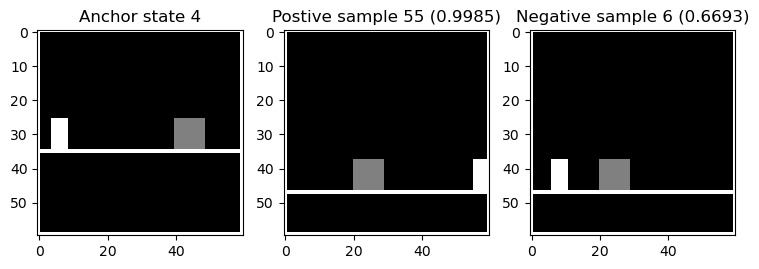

tensor([0.8793, 0.8792, 0.8790, 0.8788, 0.8786, 0.8782, 0.8778, 0.8773, 0.8767,
        0.8759, 0.8749, 0.8737, 0.8721, 0.8702, 0.8678, 0.8649, 0.8612, 0.8565,
        0.8508, 0.8437, 0.8349, 0.8240, 0.8106, 0.7942, 0.7741, 0.7498, 0.5898,
        0.7498, 1.0000, 0.7942, 0.8106, 0.8240, 0.8349, 0.8437, 0.8508, 0.8565,
        0.8612, 0.8649, 0.8678, 0.8702, 0.8721, 0.8737, 0.8749, 0.8759, 0.8767,
        0.8773, 0.8778, 0.8782, 0.8786, 0.8788, 0.8790, 0.8792, 0.8793, 0.8794,
        0.8795, 0.8796])


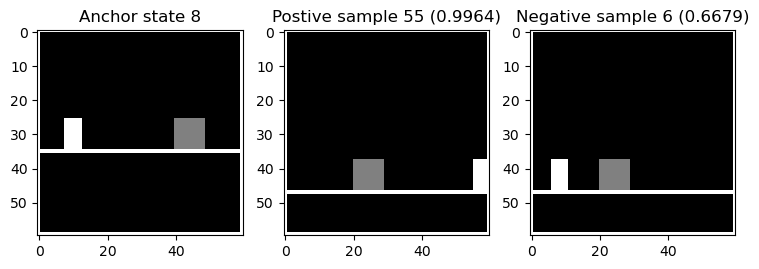

tensor([0.9483, 0.9482, 0.9480, 0.9478, 0.9475, 0.9472, 0.9467, 0.9462, 0.9455,
        0.9447, 0.9436, 0.9423, 0.9406, 0.9385, 0.9360, 0.9328, 0.9288, 0.9238,
        0.9176, 0.9099, 0.9005, 0.8887, 0.8743, 0.8566, 0.8349, 0.8086, 0.6361,
        0.8086, 0.8349, 0.8566, 0.8743, 0.8887, 1.0000, 0.9099, 0.9176, 0.9238,
        0.9288, 0.9328, 0.9360, 0.9385, 0.9406, 0.9423, 0.9436, 0.9447, 0.9455,
        0.9462, 0.9467, 0.9472, 0.9475, 0.9478, 0.9480, 0.9482, 0.9483, 0.9485,
        0.9486, 0.9486])


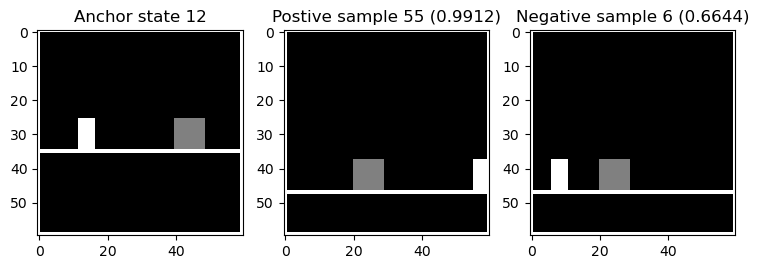

tensor([0.9782, 0.9780, 0.9778, 0.9776, 0.9773, 0.9770, 0.9765, 0.9759, 0.9752,
        0.9744, 0.9733, 0.9719, 0.9702, 0.9681, 0.9654, 0.9621, 0.9580, 0.9528,
        0.9465, 0.9386, 0.9288, 0.9167, 0.9018, 0.8835, 0.8612, 0.8340, 0.6561,
        0.8340, 0.8612, 0.8835, 0.9018, 0.9167, 0.9288, 0.9386, 0.9465, 0.9528,
        1.0000, 0.9621, 0.9654, 0.9681, 0.9702, 0.9719, 0.9733, 0.9744, 0.9752,
        0.9759, 0.9765, 0.9770, 0.9773, 0.9776, 0.9778, 0.9780, 0.9782, 0.9783,
        0.9784, 0.9785])


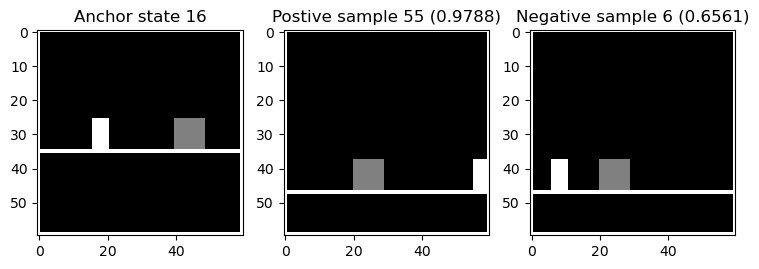

tensor([0.9906, 0.9905, 0.9903, 0.9901, 0.9898, 0.9894, 0.9890, 0.9884, 0.9877,
        0.9868, 0.9857, 0.9843, 0.9826, 0.9804, 0.9777, 0.9744, 0.9702, 0.9650,
        0.9585, 0.9505, 0.9406, 0.9284, 0.9133, 0.8948, 0.8721, 0.8447, 0.6644,
        0.8447, 0.8721, 0.8948, 0.9133, 0.9284, 0.9406, 0.9505, 0.9585, 0.9650,
        0.9702, 0.9744, 0.9777, 0.9804, 1.0000, 0.9843, 0.9857, 0.9868, 0.9877,
        0.9884, 0.9890, 0.9894, 0.9898, 0.9901, 0.9903, 0.9905, 0.9906, 0.9908,
        0.9909, 0.9909])


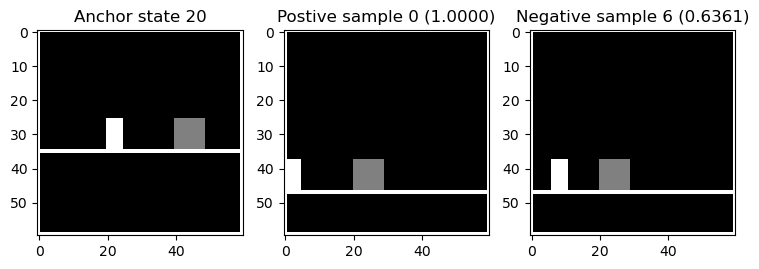

tensor([0.9958, 0.9957, 0.9955, 0.9952, 0.9949, 0.9946, 0.9941, 0.9935, 0.9928,
        0.9919, 0.9908, 0.9894, 0.9877, 0.9855, 0.9828, 0.9794, 0.9752, 0.9700,
        0.9635, 0.9555, 0.9455, 0.9332, 0.9180, 0.8994, 0.8767, 0.8491, 0.6679,
        0.8491, 0.8767, 0.8994, 0.9180, 0.9332, 0.9455, 0.9555, 0.9635, 0.9700,
        0.9752, 0.9794, 0.9828, 0.9855, 0.9877, 0.9894, 0.9908, 0.9919, 1.0000,
        0.9935, 0.9941, 0.9946, 0.9949, 0.9952, 0.9955, 0.9957, 0.9958, 0.9959,
        0.9960, 0.9961])


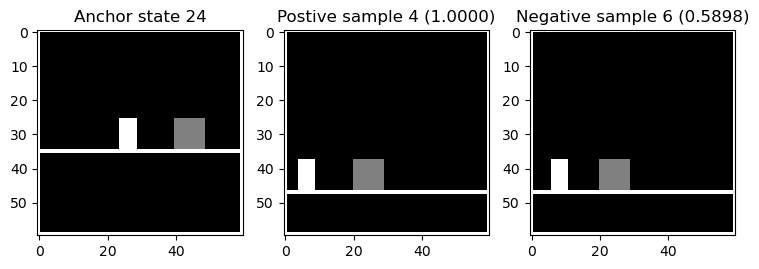

tensor([0.9979, 0.9978, 0.9976, 0.9973, 0.9971, 0.9967, 0.9962, 0.9957, 0.9949,
        0.9940, 0.9929, 0.9915, 0.9898, 0.9876, 0.9849, 0.9815, 0.9773, 0.9721,
        0.9656, 0.9575, 0.9475, 0.9352, 0.9200, 0.9013, 0.8786, 0.8509, 0.6693,
        0.8509, 0.8786, 0.9013, 0.9200, 0.9352, 0.9475, 0.9575, 0.9656, 0.9721,
        0.9773, 0.9815, 0.9849, 0.9876, 0.9898, 0.9915, 0.9929, 0.9940, 0.9949,
        0.9957, 0.9962, 0.9967, 1.0000, 0.9973, 0.9976, 0.9978, 0.9979, 0.9980,
        0.9981, 0.9982])


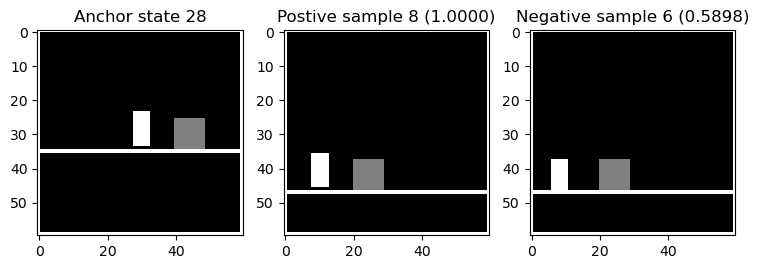

tensor([0.9988, 0.9986, 0.9985, 0.9982, 0.9979, 0.9976, 0.9971, 0.9965, 0.9958,
        0.9949, 0.9938, 0.9924, 0.9906, 0.9885, 0.9858, 0.9824, 0.9782, 0.9729,
        0.9664, 0.9583, 0.9483, 0.9360, 0.9208, 0.9021, 0.8793, 0.8516, 0.6699,
        0.8516, 0.8793, 0.9021, 0.9208, 0.9360, 0.9483, 0.9583, 0.9664, 0.9729,
        0.9782, 0.9824, 0.9858, 0.9885, 0.9906, 0.9924, 0.9938, 0.9949, 0.9958,
        0.9965, 0.9971, 0.9976, 0.9979, 0.9982, 0.9985, 0.9986, 1.0000, 0.9989,
        0.9990, 0.9991])


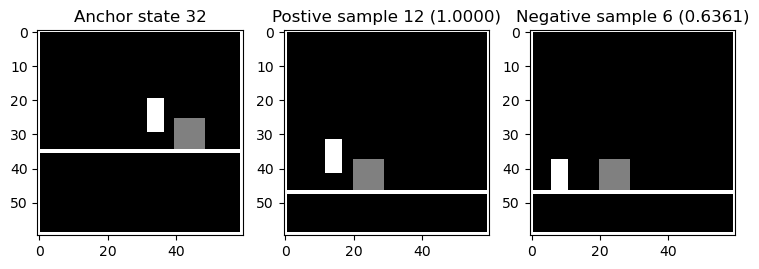

tensor([0.9991, 0.9990, 0.9988, 0.9986, 0.9983, 0.9979, 0.9974, 0.9969, 0.9962,
        0.9953, 0.9941, 0.9927, 0.9910, 0.9888, 0.9861, 0.9827, 0.9785, 0.9733,
        0.9668, 0.9587, 0.9487, 0.9363, 0.9211, 0.9024, 0.8796, 0.8519, 0.6702,
        0.8519, 0.8796, 0.9024, 0.9211, 0.9363, 0.9487, 0.9587, 0.9668, 0.9733,
        0.9785, 0.9827, 0.9861, 0.9888, 0.9910, 0.9927, 0.9941, 0.9953, 0.9962,
        0.9969, 0.9974, 0.9979, 0.9983, 0.9986, 0.9988, 0.9990, 0.9991, 0.9993,
        0.9994, 0.9994])


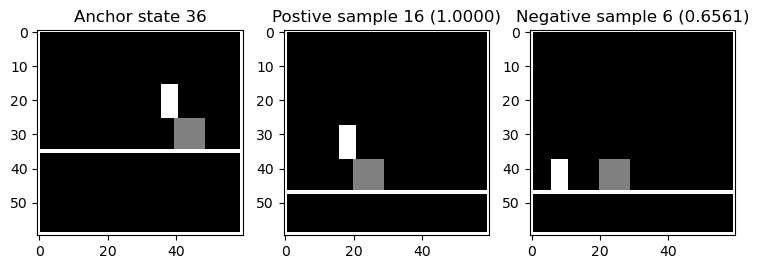

tensor([0.9993, 0.9991, 0.9990, 0.9987, 0.9984, 0.9981, 0.9976, 0.9970, 0.9963,
        0.9954, 0.9943, 0.9929, 0.9911, 0.9890, 0.9863, 0.9829, 0.9787, 0.9734,
        0.9669, 0.9588, 0.9488, 0.9365, 0.9213, 0.9026, 0.8798, 0.8521, 0.6703,
        0.8521, 0.8798, 0.9026, 0.9213, 0.9365, 0.9488, 0.9588, 0.9669, 0.9734,
        0.9787, 0.9829, 0.9863, 0.9890, 0.9911, 0.9929, 0.9943, 0.9954, 0.9963,
        0.9970, 0.9976, 0.9981, 0.9984, 0.9987, 0.9990, 0.9991, 0.9993, 0.9994,
        0.9995, 0.9996])


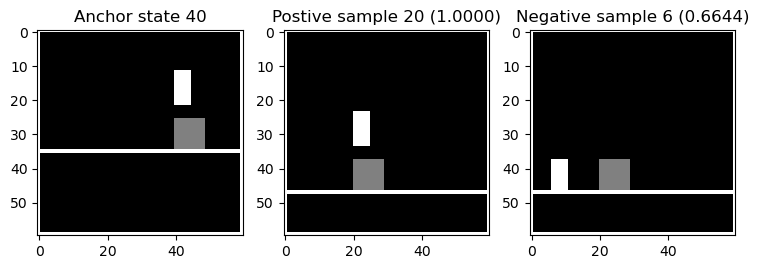

tensor([0.9994, 0.9992, 0.9990, 0.9988, 0.9985, 0.9981, 0.9977, 0.9971, 0.9964,
        0.9955, 0.9943, 0.9929, 0.9912, 0.9890, 0.9863, 0.9829, 0.9787, 0.9735,
        0.9670, 0.9589, 0.9489, 0.9365, 0.9213, 0.9026, 0.8798, 0.8521, 0.6703,
        0.8521, 0.8798, 0.9026, 0.9213, 0.9365, 0.9489, 0.9589, 0.9670, 0.9735,
        0.9787, 0.9829, 0.9863, 0.9890, 0.9912, 0.9929, 0.9943, 0.9955, 0.9964,
        0.9971, 0.9977, 0.9981, 0.9985, 0.9988, 0.9990, 0.9992, 0.9994, 0.9995,
        0.9996, 0.9996])


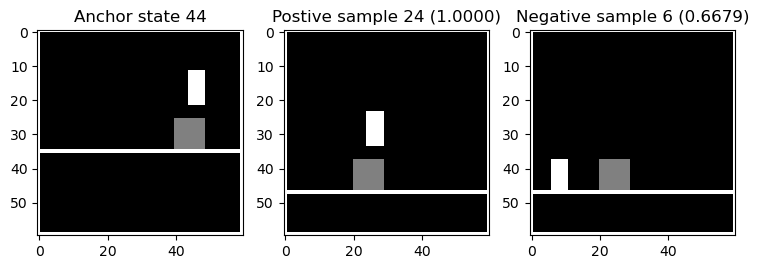

tensor([0.9994, 0.9992, 0.9990, 0.9988, 0.9985, 0.9981, 0.9977, 0.9971, 0.9964,
        0.9955, 0.9944, 0.9930, 0.9912, 0.9890, 0.9863, 0.9830, 0.9787, 0.9735,
        0.9670, 0.9589, 0.9489, 0.9365, 0.9213, 0.9027, 0.8798, 0.8521, 0.6703,
        0.8521, 0.8798, 0.9027, 0.9213, 0.9365, 0.9489, 0.9589, 0.9670, 0.9735,
        0.9787, 0.9830, 0.9863, 0.9890, 0.9912, 0.9930, 0.9944, 0.9955, 0.9964,
        0.9971, 0.9977, 0.9981, 0.9985, 0.9988, 0.9990, 0.9992, 0.9994, 0.9995,
        0.9996, 0.9997])


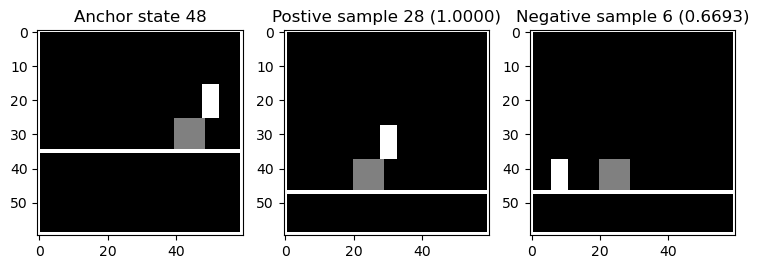

tensor([0.9994, 0.9992, 0.9990, 0.9988, 0.9985, 0.9982, 0.9977, 0.9971, 0.9964,
        0.9955, 0.9944, 0.9930, 0.9912, 0.9891, 0.9863, 0.9830, 0.9787, 0.9735,
        0.9670, 0.9589, 0.9489, 0.9366, 0.9213, 0.9027, 0.8798, 0.8521, 0.6703,
        0.8521, 0.8798, 0.9027, 0.9213, 0.9366, 0.9489, 0.9589, 0.9670, 0.9735,
        0.9787, 0.9830, 0.9863, 0.9891, 0.9912, 0.9930, 0.9944, 0.9955, 0.9964,
        0.9971, 0.9977, 0.9982, 0.9985, 0.9988, 0.9990, 0.9992, 0.9994, 0.9995,
        0.9996, 0.9997])


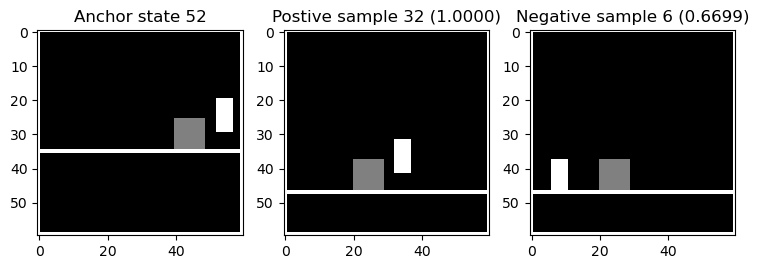

In [52]:
# Some experiments for triplet loss
psm_mat = psm.psm_fb_fast(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.8)

beta = 5
psm_mat = np.exp(-psm_mat/beta)

for compare_idx in range(0, len(actions_x)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    idx_positive = np.argmax(psm_mat[compare_idx, :])
    idx_negative = np.argmin(psm_mat[compare_idx, :])

    if compare_idx % 4 == 0:
        print(psm_mat[:,compare_idx])
        compare_imgs(
            states_x[compare_idx], 
            states_y[idx_positive], 
            states_y[idx_negative], 
            f"Anchor state {compare_idx}",
            f"Postive sample {idx_positive} ({psm_mat[compare_idx][idx_positive]:.4f})", 
            f"Negative sample {idx_negative} ({psm_mat[compare_idx][idx_negative]:.4f})")


PSM F: mean: 0.4553820490837097 var: 0.24806345999240875
PSM FB: mean: 0.011479591950774193 var: 0.011351430788636208


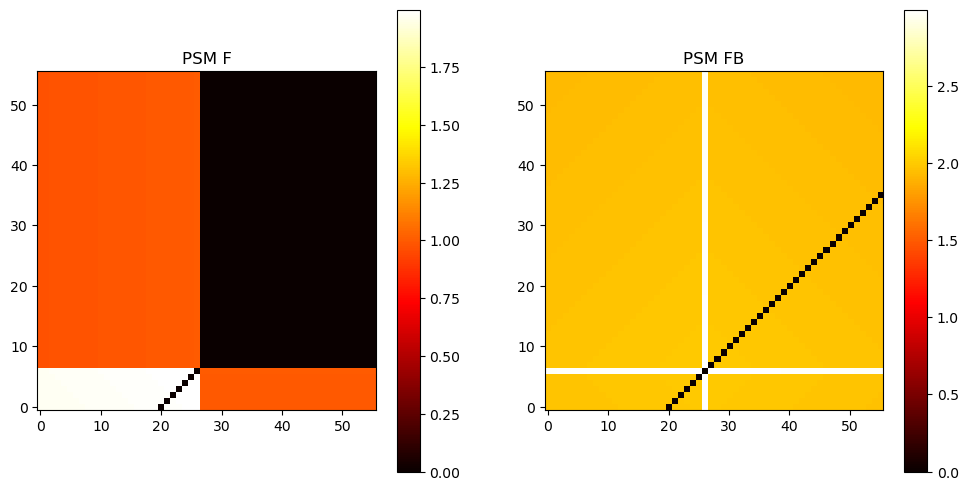

In [53]:
psm_f = psm.psm_f_fast(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.999)
psm_fb = psm.psm_fb_fast(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.999)

# calculate measure

beta = .1
psm_f_measure = torch.exp(-psm_f/beta)
psm_fb_measure = torch.exp(-psm_fb/beta)

print(f"PSM F: mean: {psm_f_measure.mean()} var: {psm_f_measure.var()}")
print(f"PSM FB: mean: {psm_fb_measure.mean()} var: {psm_fb_measure.var()}")


fig = plt.figure(figsize=(12,6))
plot1 = fig.add_subplot(1, 2, 1)
im = plot1.imshow(psm_f.T, origin='lower', cmap='hot', interpolation='nearest')
plot1.set_title("PSM F")
fig.colorbar(im, ax=plot1)


plot2 = fig.add_subplot(1, 2, 2)
plot2.set_title("PSM FB")
im = plot2.imshow(psm_fb.T, origin='lower', cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=plot2)
plt.show()

In [54]:
print(actions_y[20])
print(actions_x[12:])
psm_f[0:,20]


0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


tensor([0.9743, 0.9753, 0.9763, 0.9773, 0.9782, 0.9792, 0.9802, 0.9812, 0.9822,
        0.9831, 0.9841, 0.9851, 0.9861, 0.9871, 0.9881, 0.9891, 0.9900, 0.9910,
        0.9920, 0.9930, 0.9940, 0.9950, 0.9960, 0.9970, 0.9980, 0.9990, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

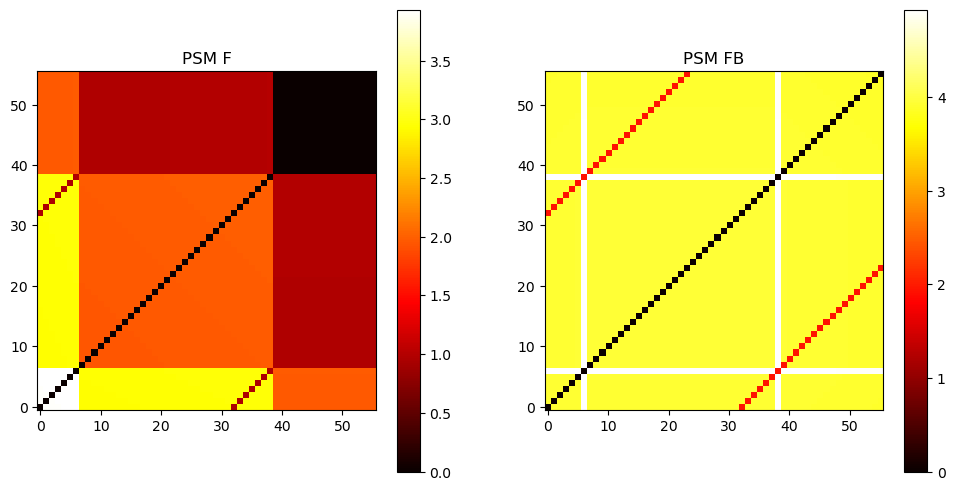

In [55]:
states_x, actions_x = generate_expert_episode(VanillaEnv(configurations=[(14, 24)], two_obstacles=True))
states_y, actions_y = generate_expert_episode(VanillaEnv(configurations=[(34, 12)], two_obstacles=True))

psm_f = psm.psm_f_fast(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.999)
psm_fb = psm.psm_fb_fast(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.999)

fig = plt.figure(figsize=(12,6))
plot1 = fig.add_subplot(1, 2, 1)
im = plot1.imshow(psm_f.T, origin='lower', cmap='hot', interpolation='nearest')
plot1.set_title("PSM F")
fig.colorbar(im, ax=plot1)


plot2 = fig.add_subplot(1, 2, 2)
plot2.set_title("PSM FB")
im = plot2.imshow(psm_fb.T, origin='lower', cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=plot2)
plt.show()

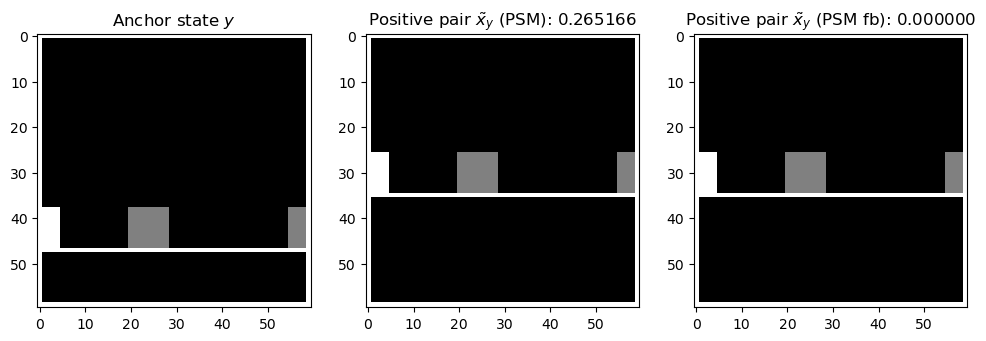

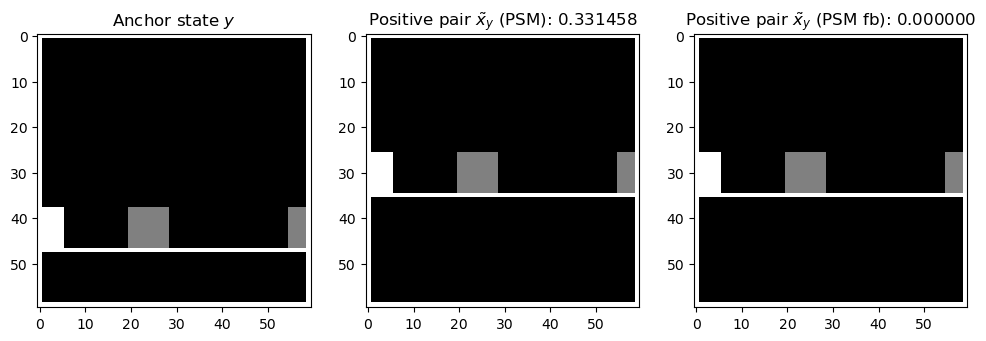

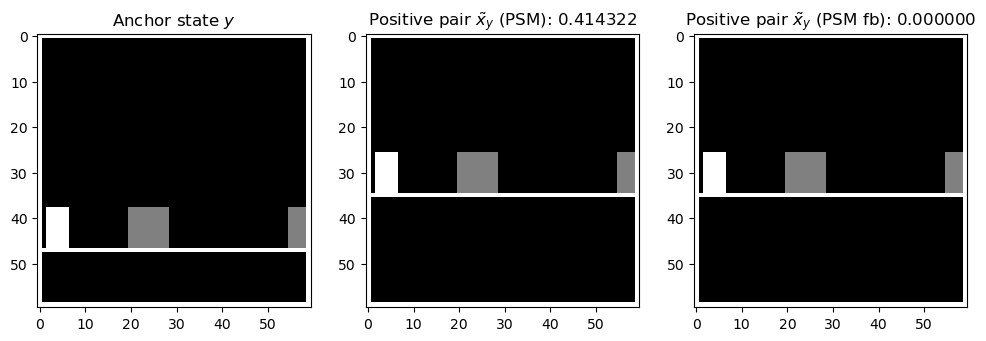

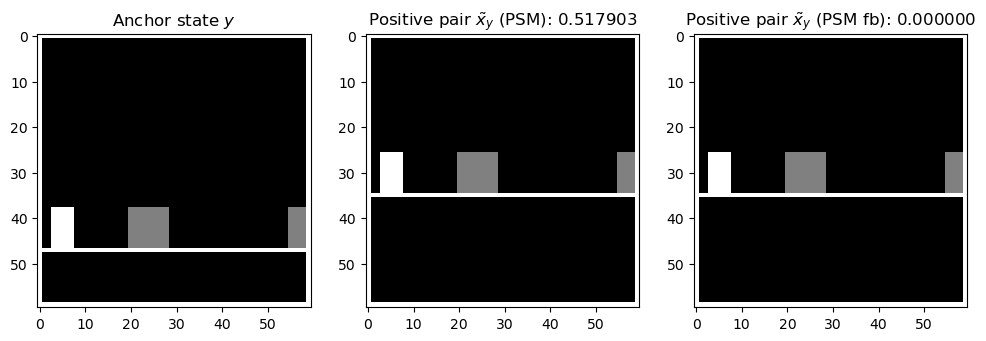

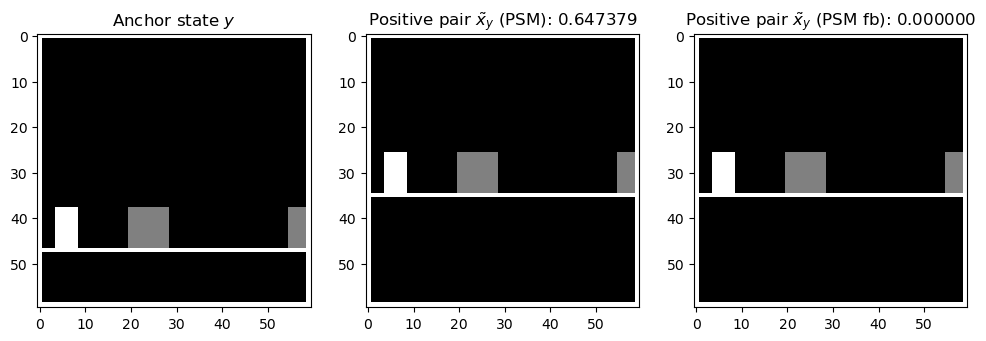

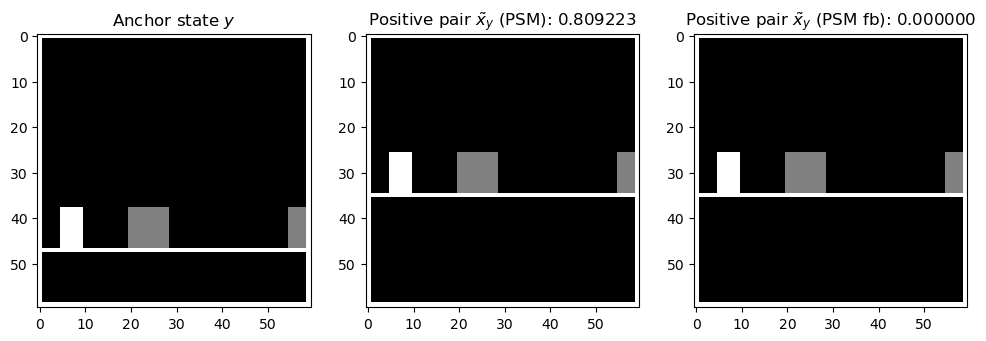

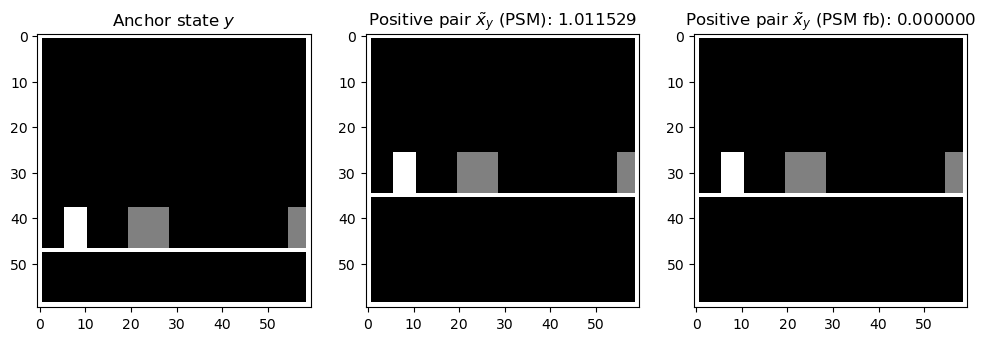

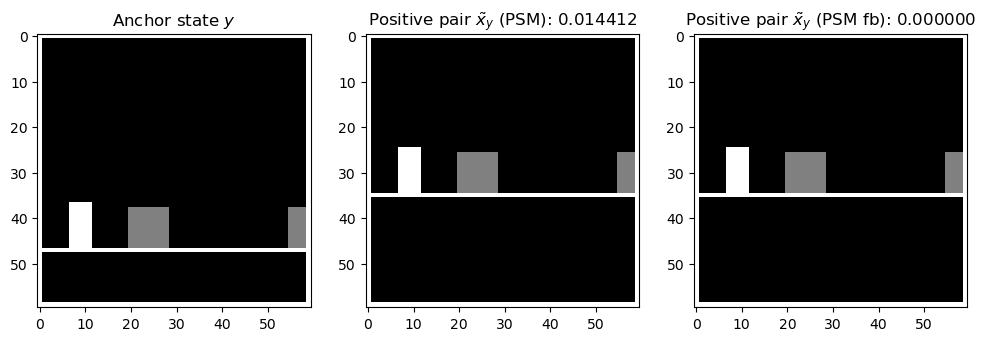

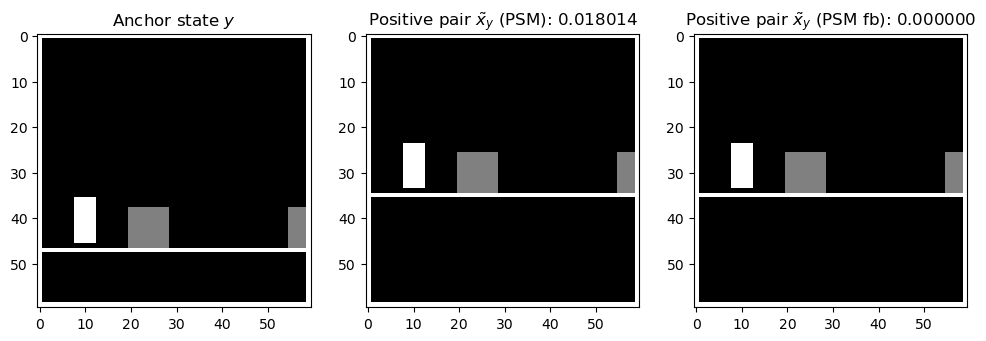

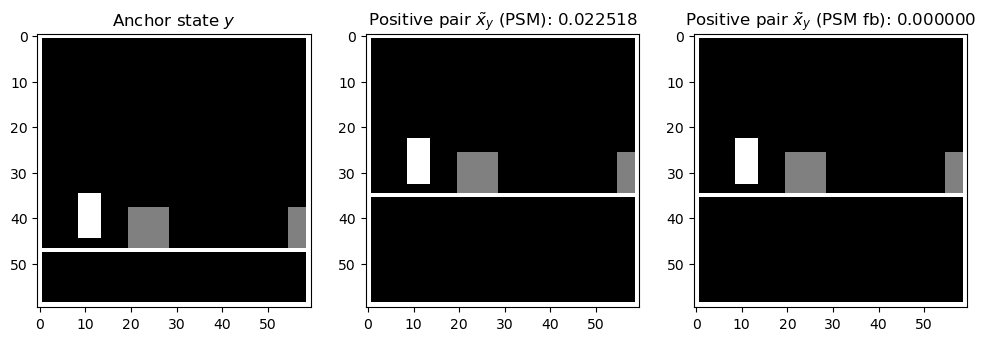

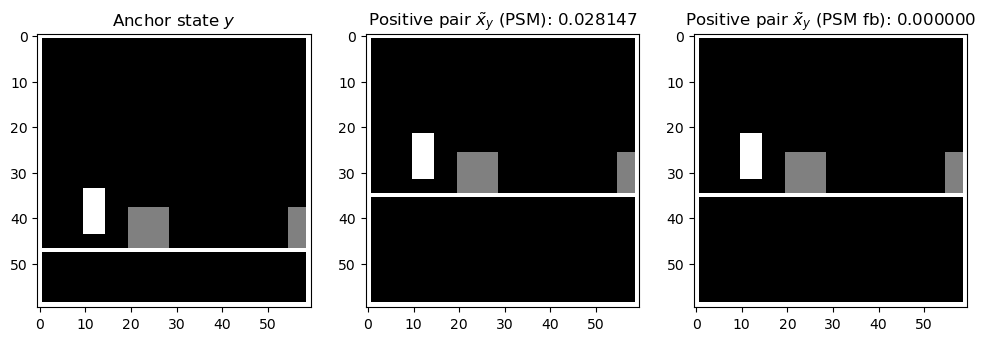

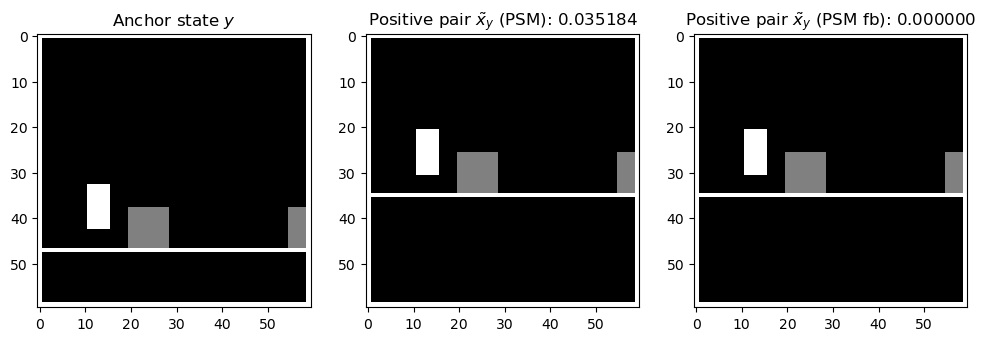

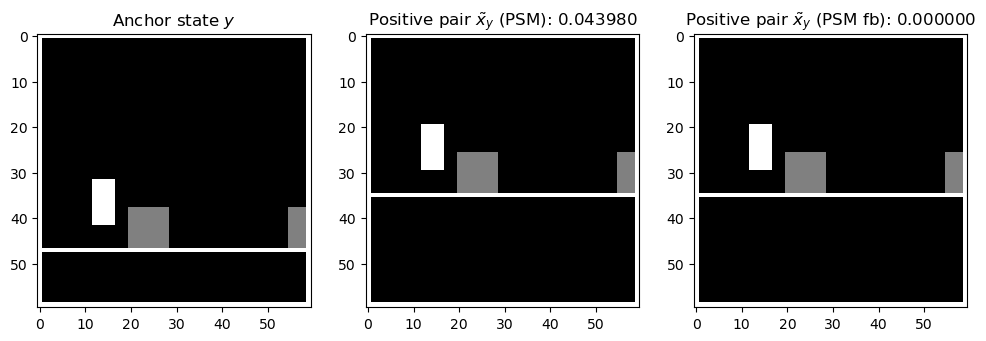

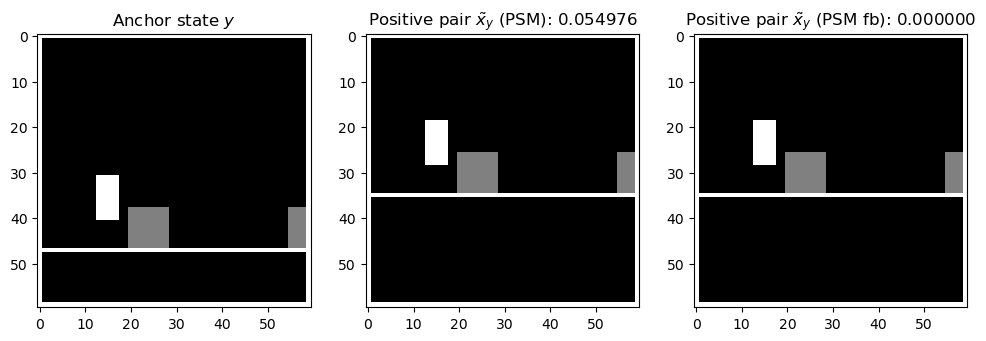

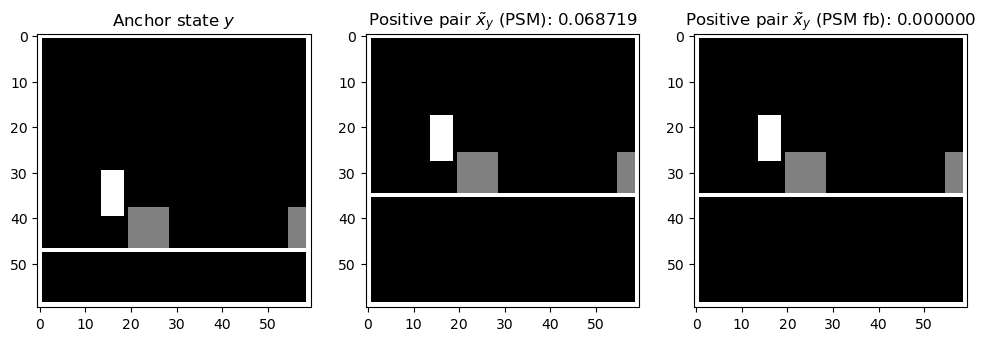

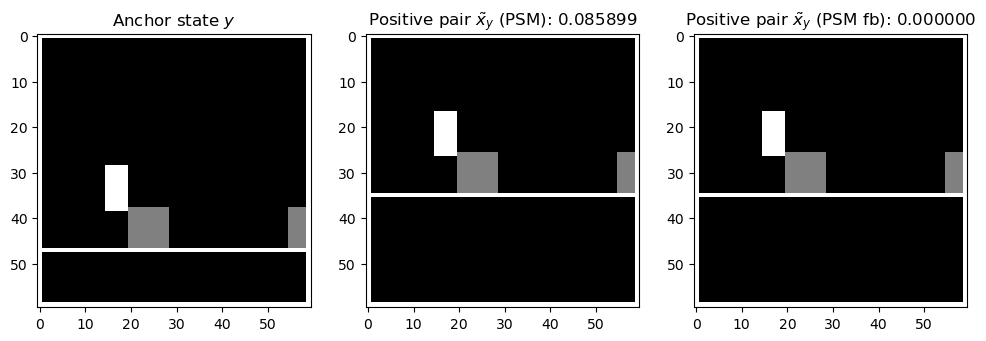

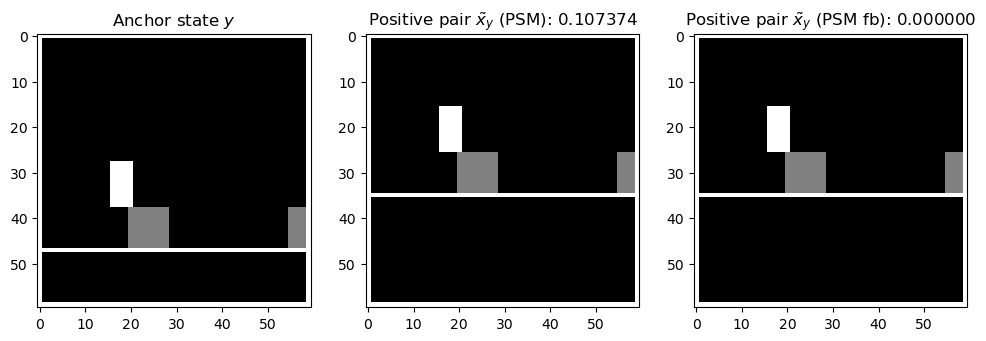

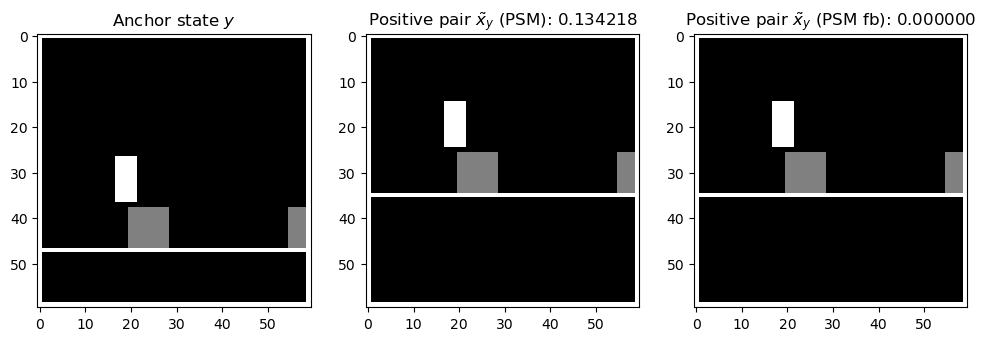

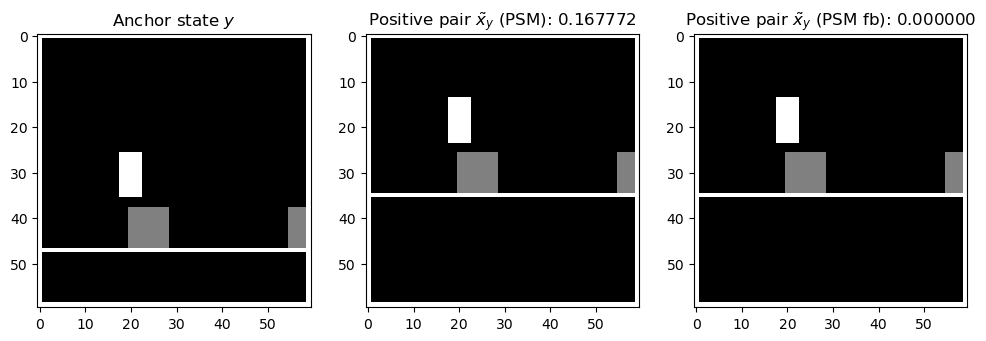

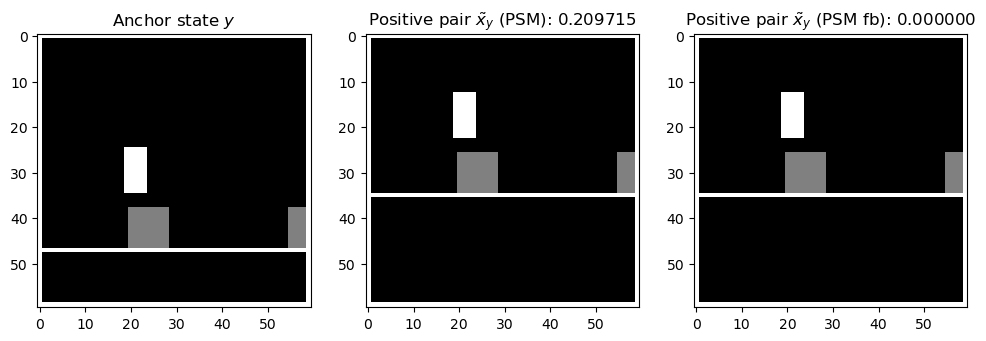

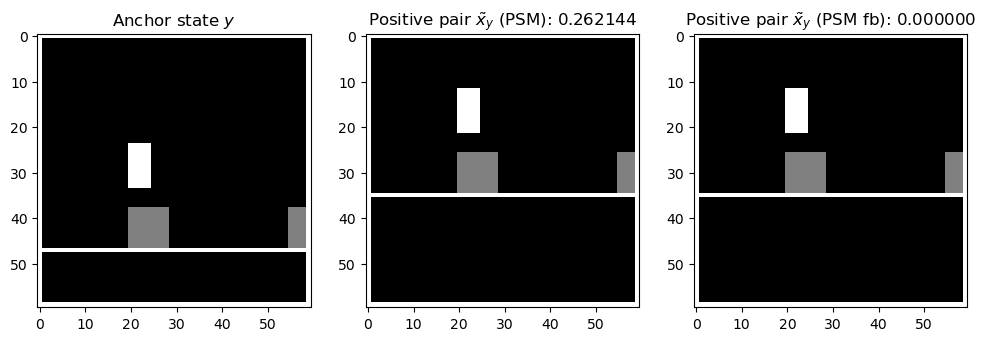

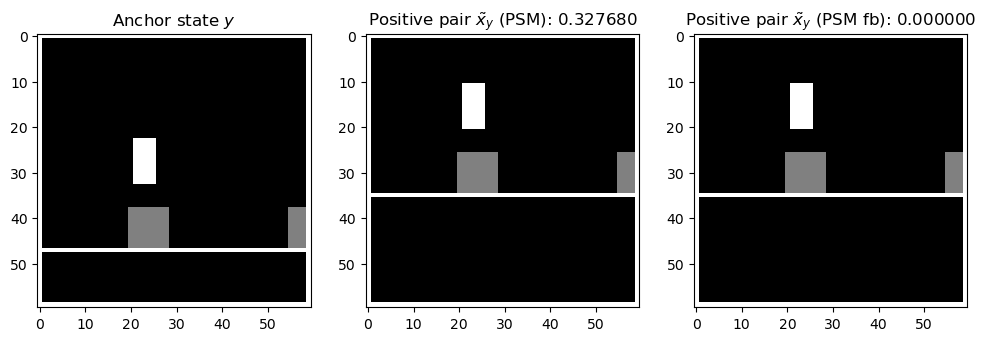

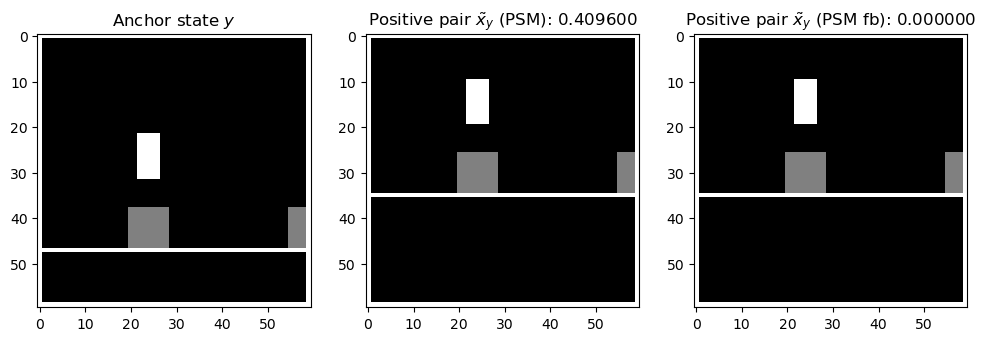

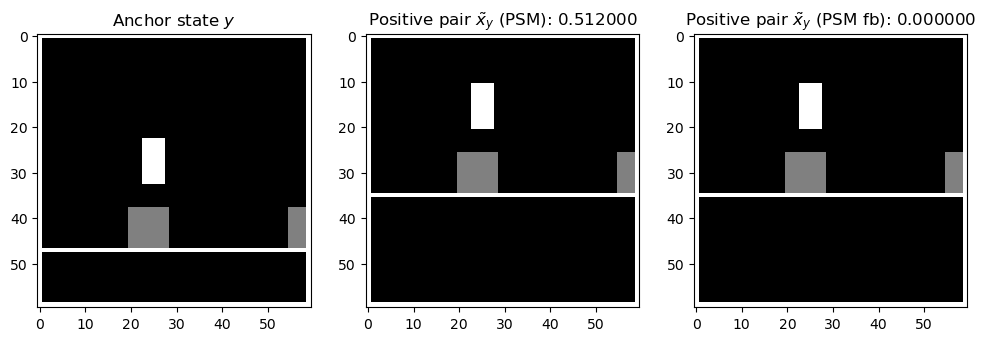

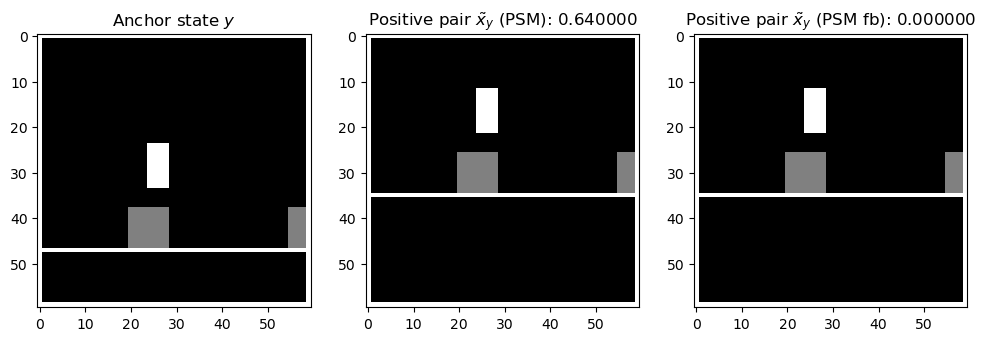

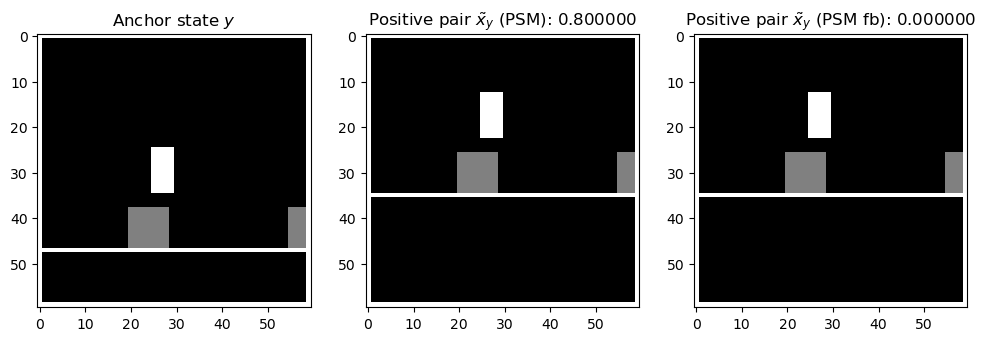

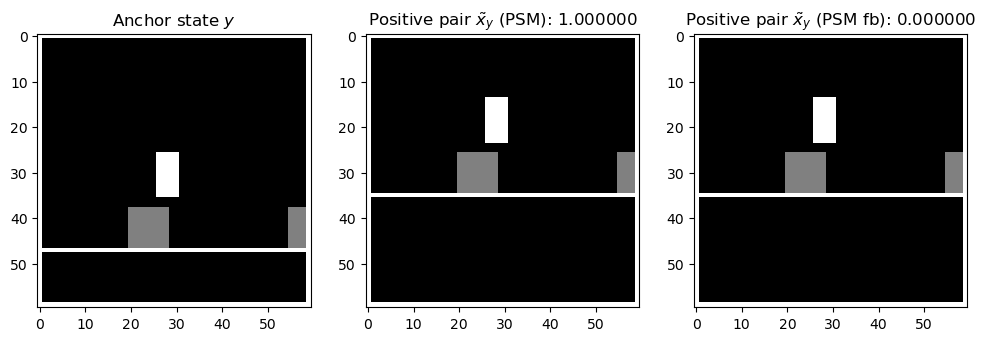

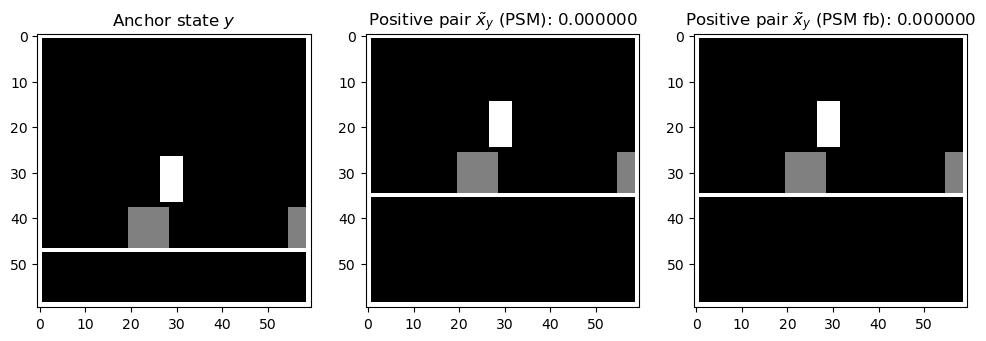

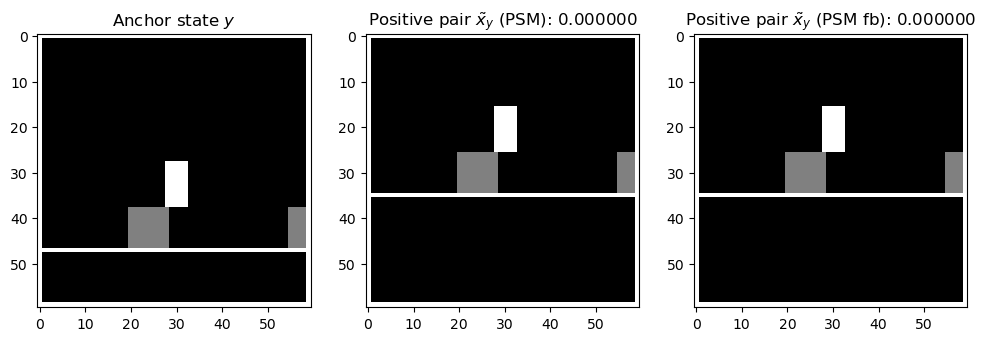

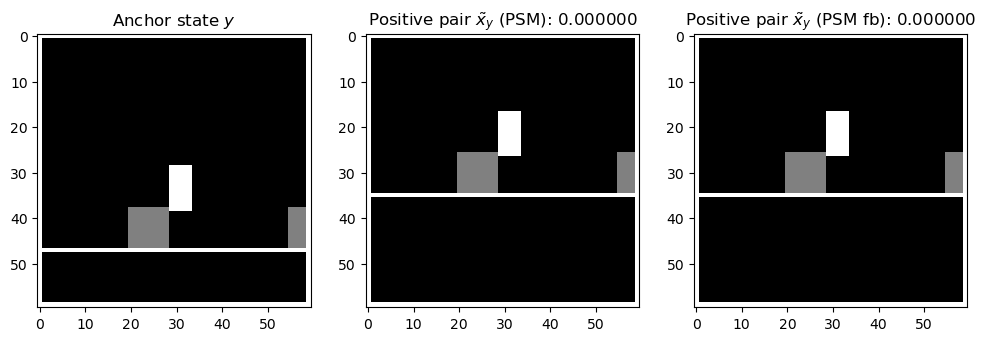

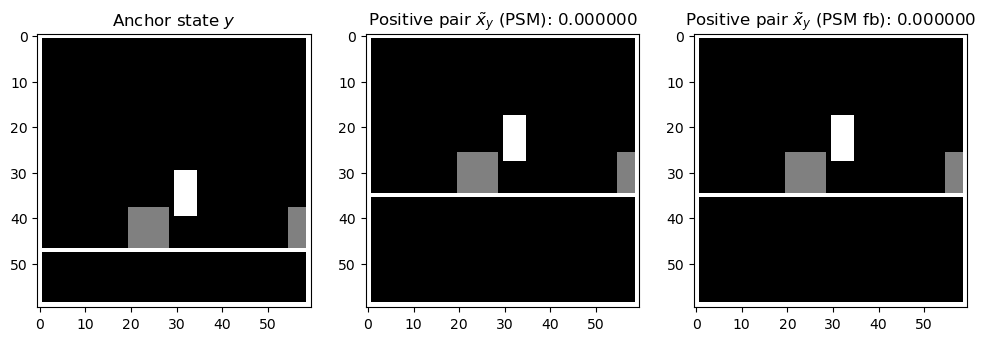

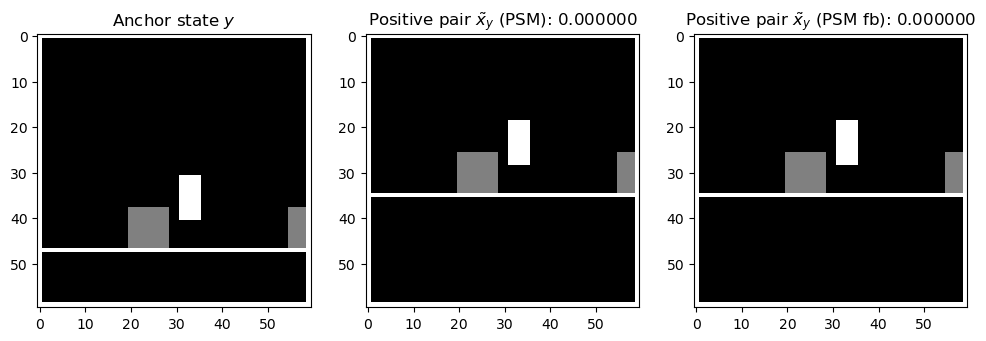

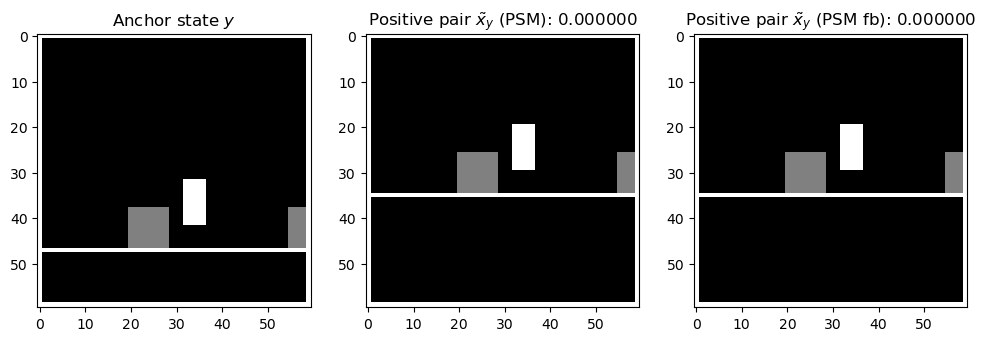

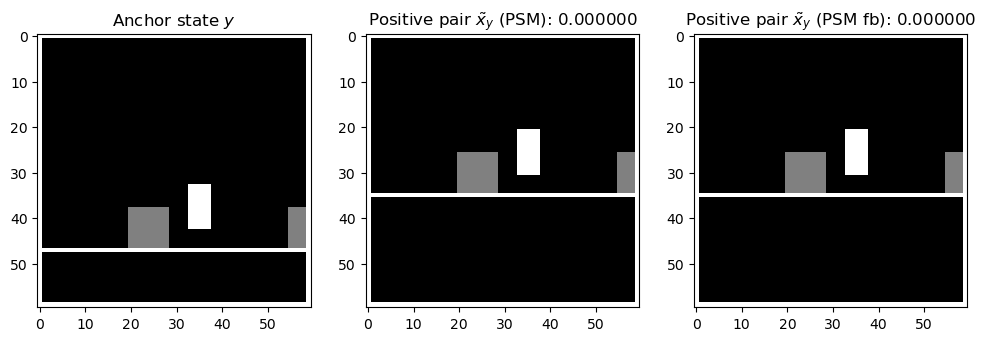

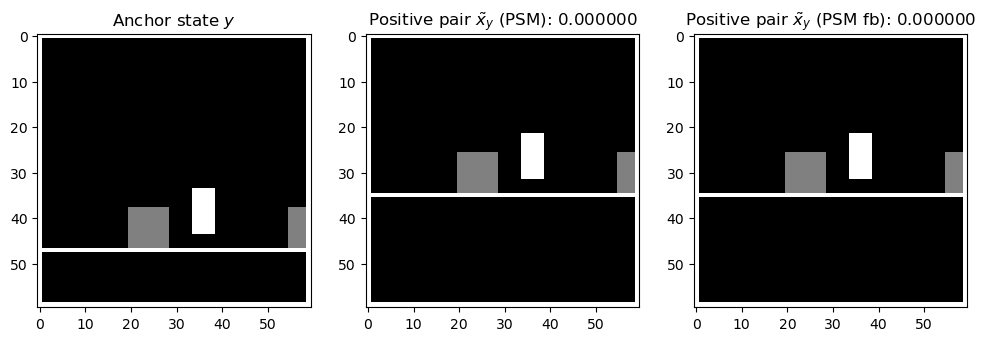

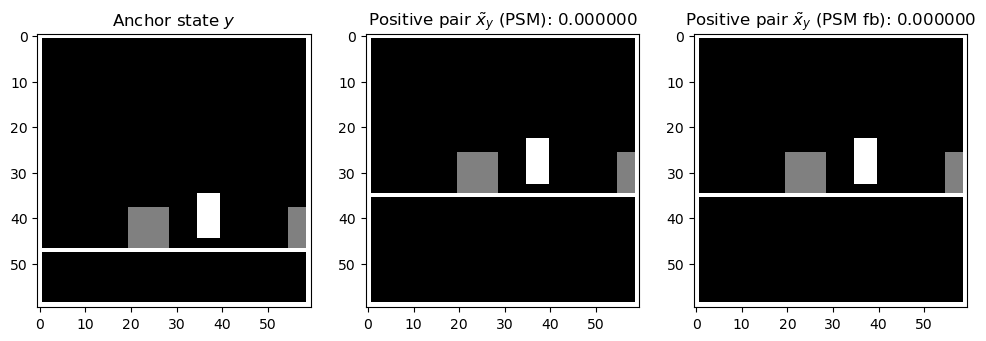

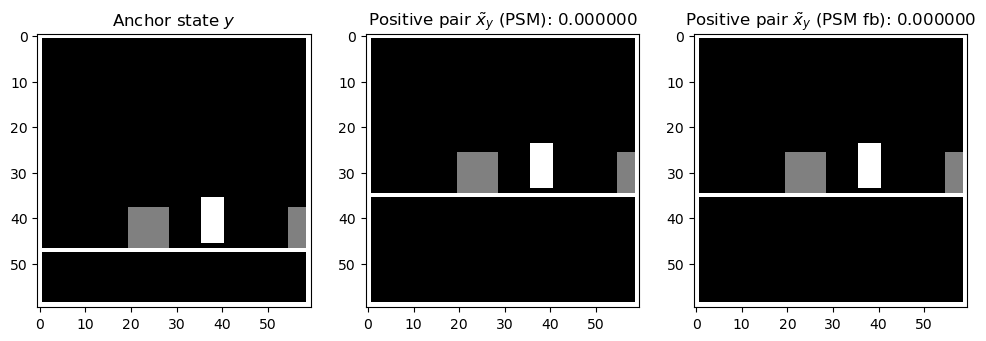

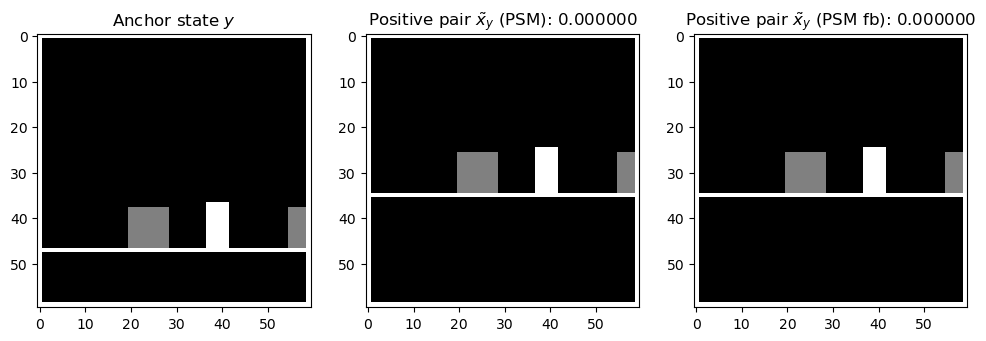

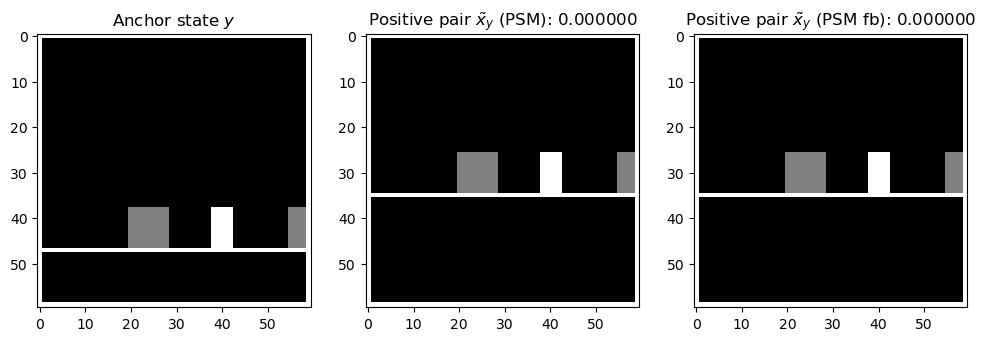

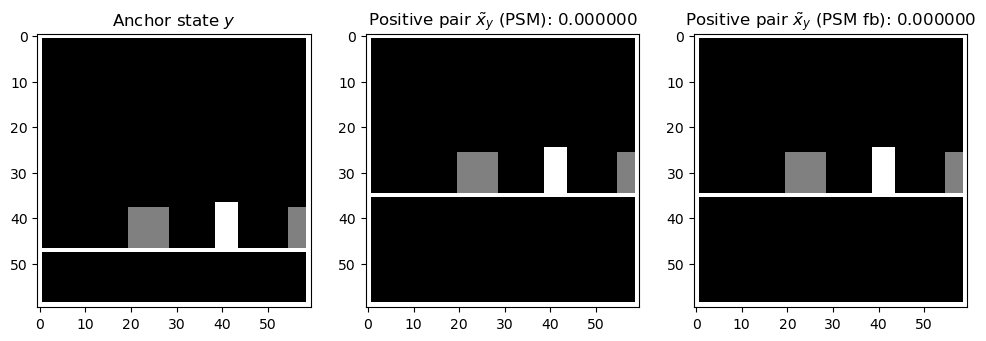

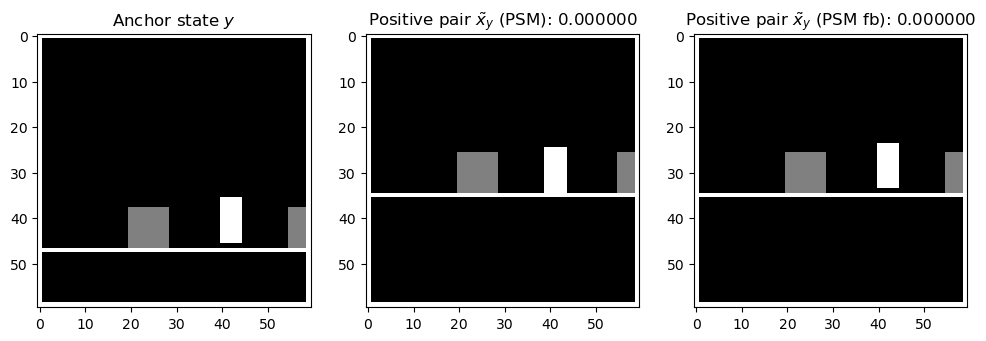

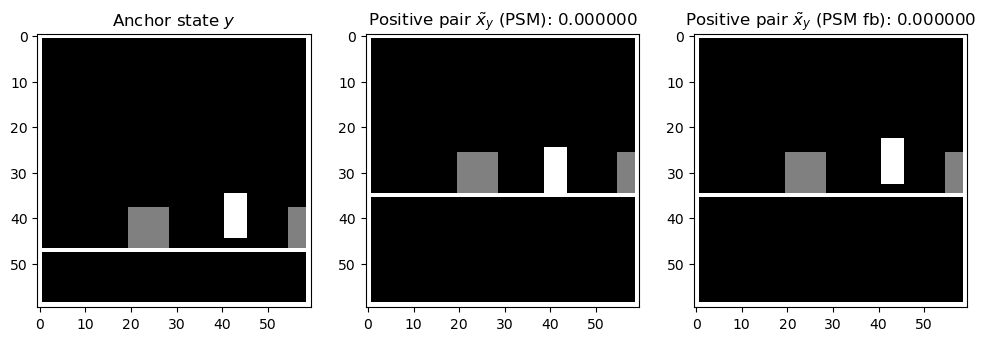

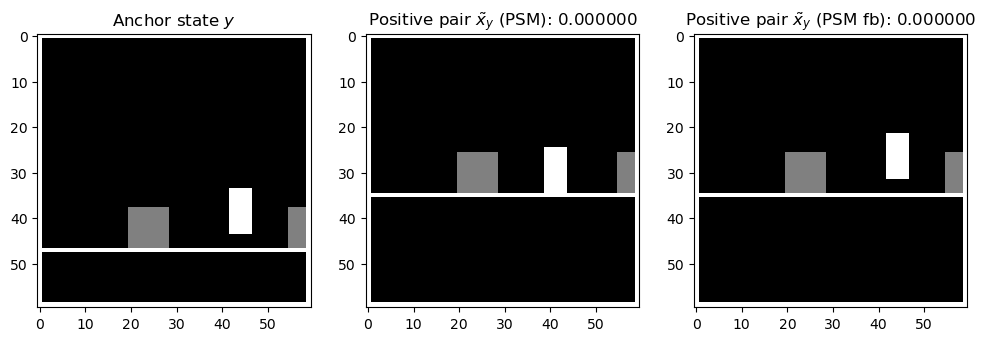

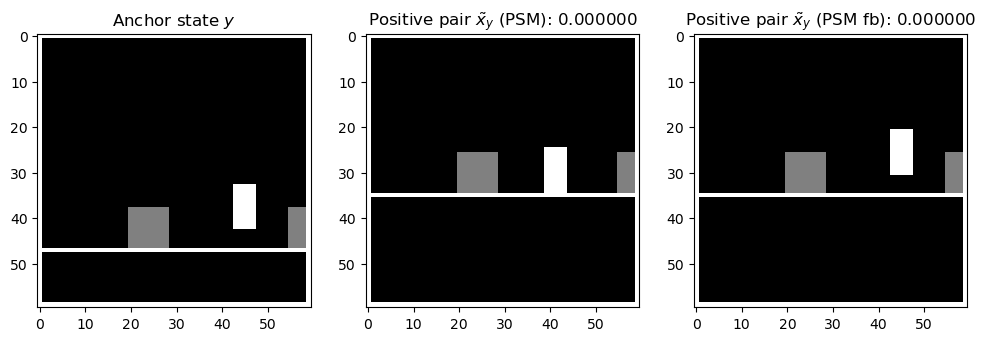

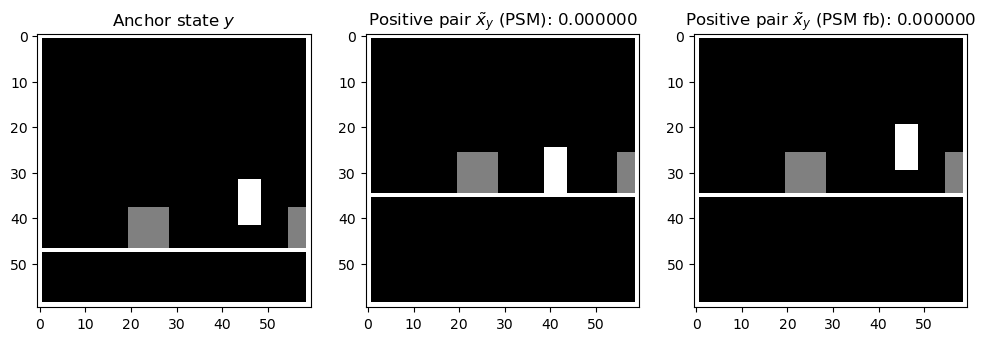

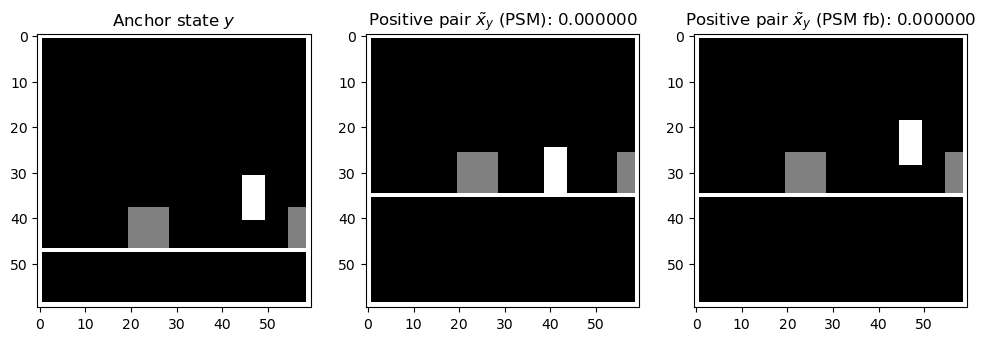

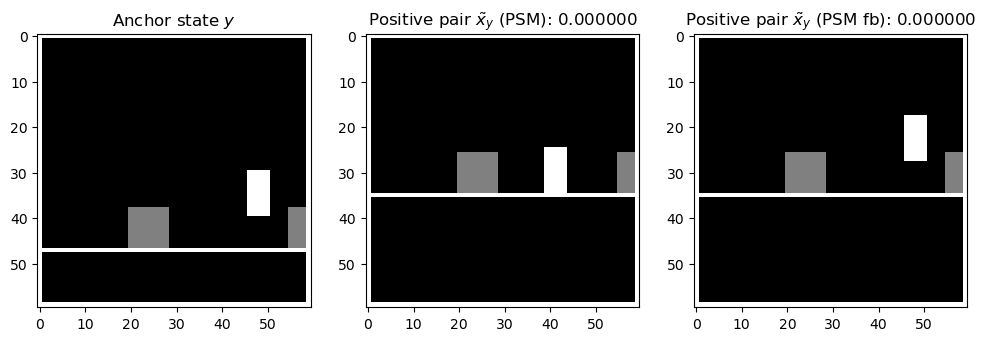

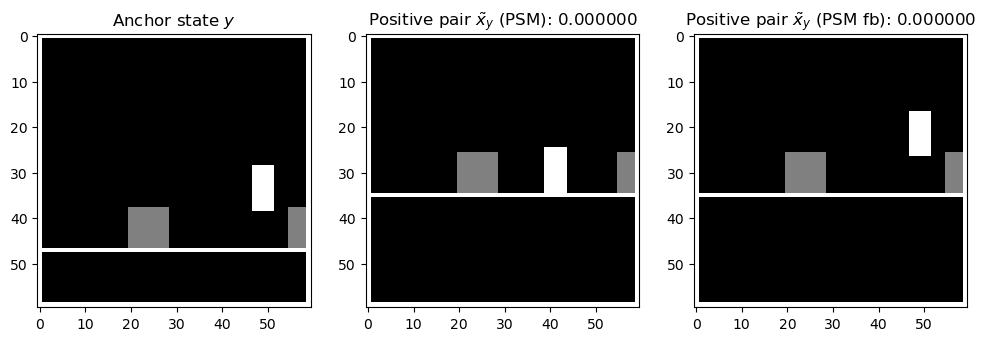

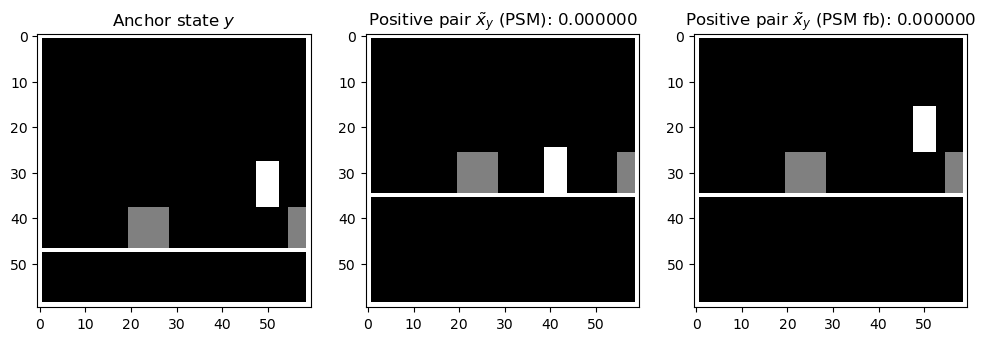

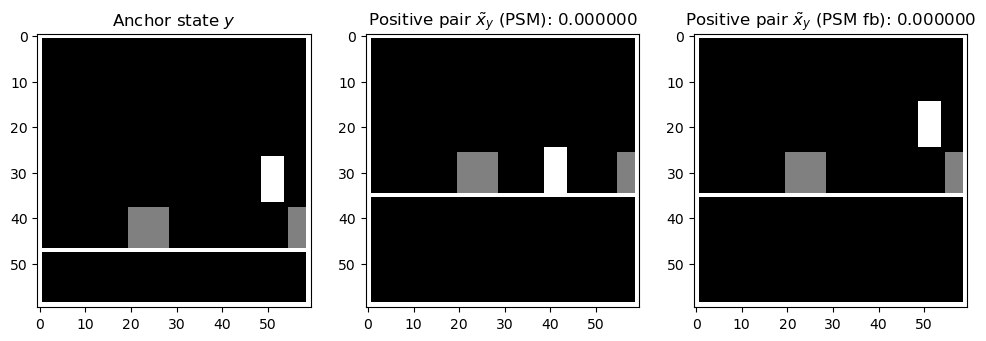

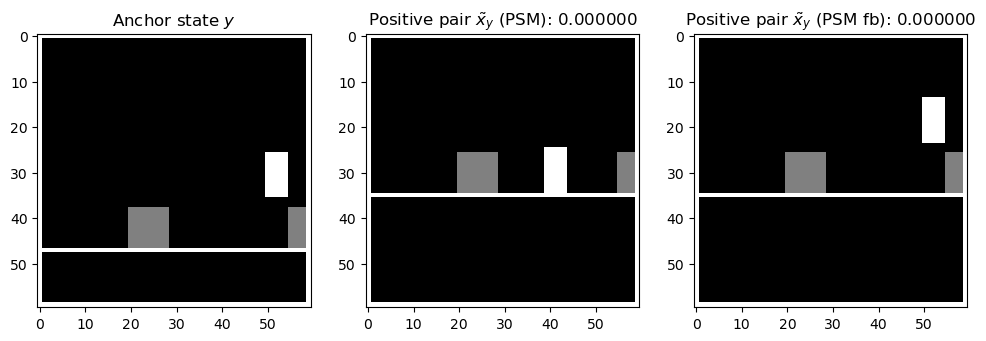

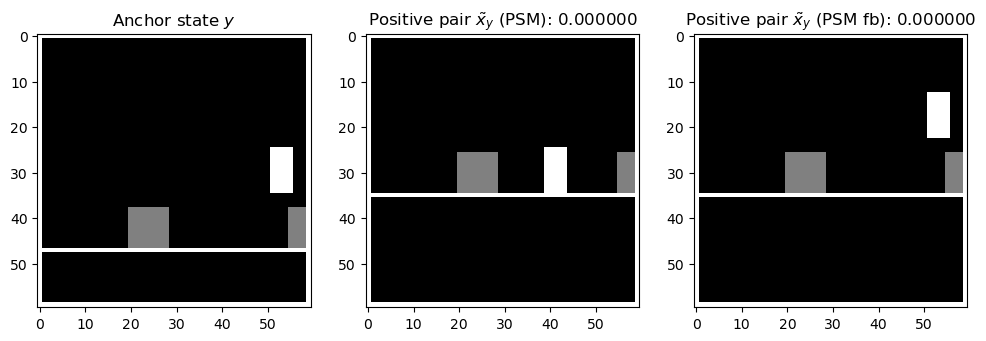

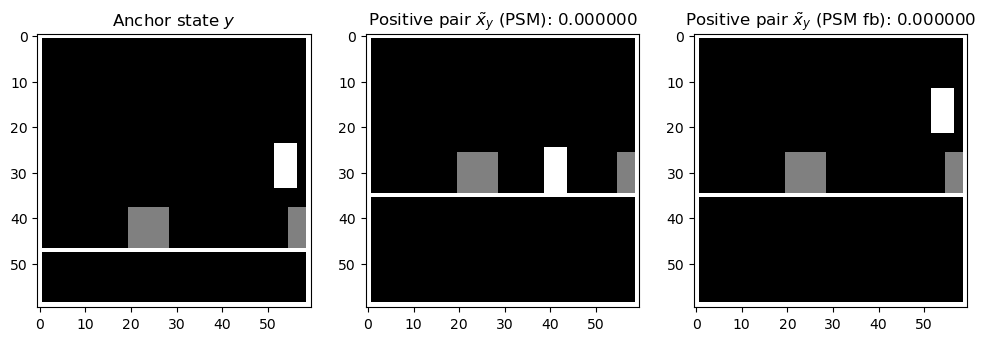

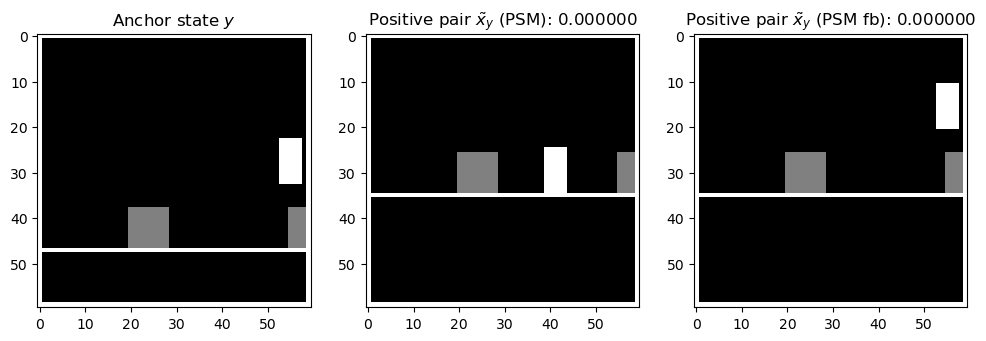

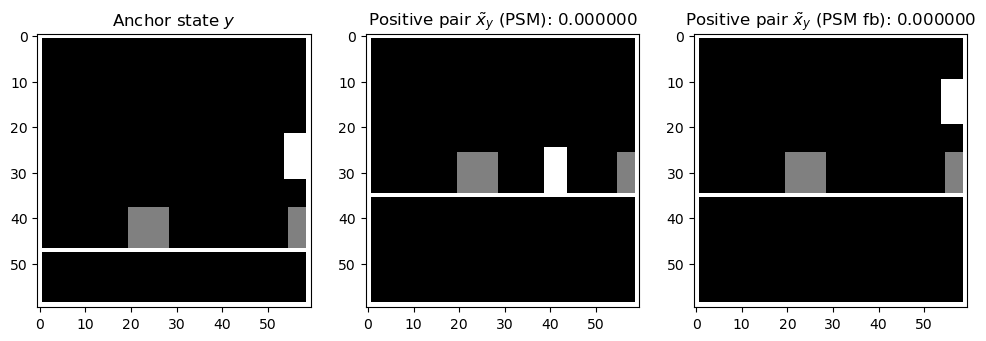

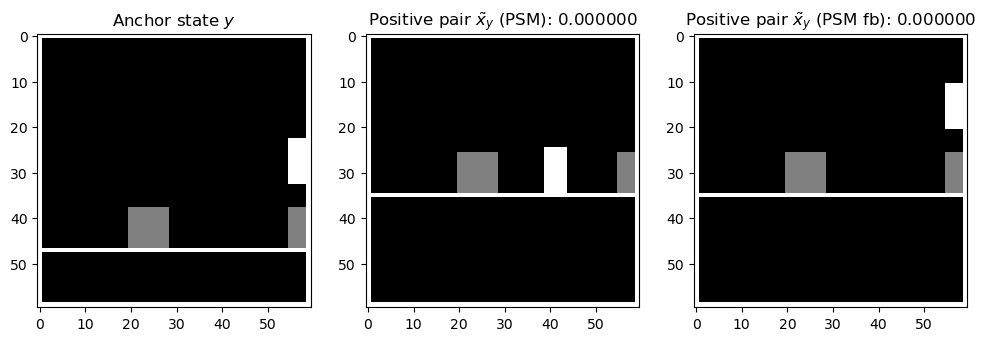

In [56]:
for compare_idx in range(0, len(actions_y)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    idx_forward = np.argmin(psm_f[:, compare_idx])
    idx_fb = np.argmin(psm_fb[:,compare_idx])

    if compare_idx >= 0:
        compare_imgs(
            states_y[compare_idx], 
            states_x[idx_forward], 
            states_x[idx_fb], 
            "Anchor state $y$",
            "Positive pair $\\tilde{x}_y$ (PSM): " + f"{psm_forward[idx_forward, compare_idx].item():.6f}",
            "Positive pair $\\tilde{x}_y$ (PSM fb): "  + f"{psm_fb[idx_fb, compare_idx].item():.6f}", 
            scale=4)